In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import sklearn.preprocessing
import sklearn.model_selection

In [8]:
import uproot
uproot.default_library = "np"

In [9]:
import os.path

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
np.set_printoptions(precision=4, suppress=True)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [13]:
raw_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [14]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [15]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Truthing

In [16]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [17]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [18]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]
features = list(aliases.keys())

In [19]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [20]:
selectors = [
    Kee_selector,
    Je_selector,
    psi2Se_selector,
    Dphipi_ee_selector,
]
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    None,
]

In [21]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [22]:
df_index = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]
df = pd.DataFrame(index=df_index)

In [23]:
df["Total"] = [f["q2_TRUE"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b["q2_TRUE"].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

### KS tests

In [24]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

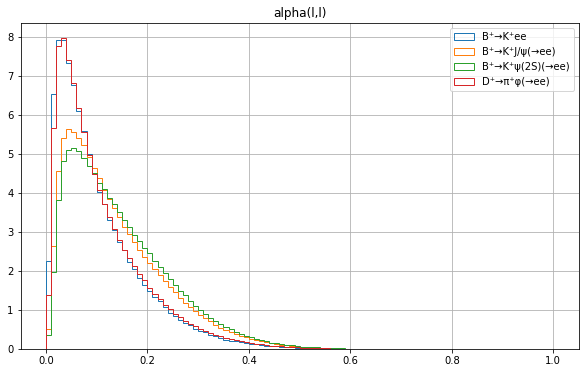

In [25]:
for idx in range(4):
    plt.hist(truthed[idx]['angle_ee_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

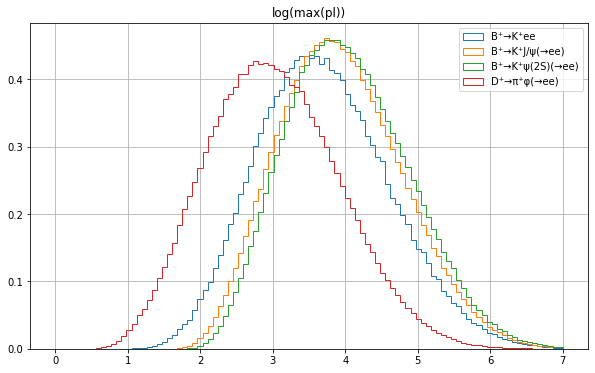

In [26]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 7, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

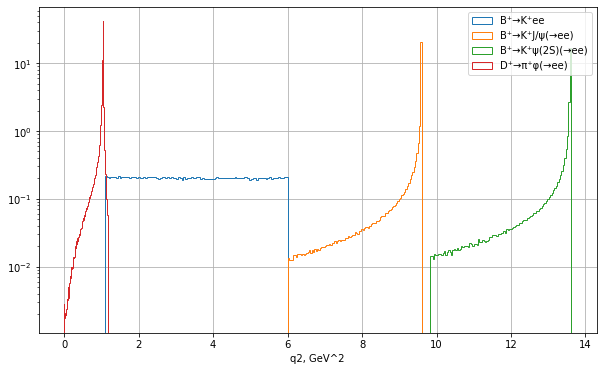

In [27]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2_TRUE'], label="%s"%df_index[idx],
             density=True, bins=100, histtype='step', log=True)
plt.xlabel(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

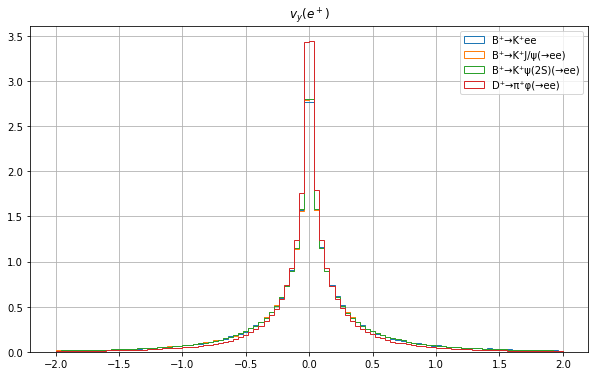

In [28]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['ep_origY_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^+)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [29]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [30]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [31]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [32]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    plt.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    plt.grid()
    plt.show()

In [33]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [34]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [35]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [36]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [37]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [38]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [39]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=100000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=100000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [40]:
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.405319
INFO:root:Epoch 1, 1.381754
INFO:root:Epoch 2, 1.374772
INFO:root:Epoch 3, 1.367733
INFO:root:Epoch 4, 1.365722
INFO:root:Epoch 5, 1.365394
INFO:root:Epoch 6, 1.365177
INFO:root:Epoch 7, 1.364999
INFO:root:Epoch 8, 1.364859
INFO:root:Epoch 9, 1.364751
INFO:root:Epoch 10, 1.364668
INFO:root:Epoch 11, 1.364579
INFO:root:Epoch 12, 1.364533
INFO:root:Epoch 13, 1.364507
INFO:root:Epoch 14, 1.364477
INFO:root:Epoch 15, 1.364406
INFO:root:Epoch 16, 1.364384
INFO:root:Epoch 17, 1.364377
INFO:root:Epoch 18, 1.364341
INFO:root:Epoch 19, 1.364325
INFO:root:Epoch 20, 1.364319
INFO:root:Epoch 21, 1.364316
INFO:root:Epoch 22, 1.364283
INFO:root:Epoch 23, 1.364271
INFO:root:Epoch 24, 1.364253
INFO:root:Epoch 25, 1.364233
INFO:root:Epoch 26, 1.364232
INFO:root:Epoch 27, 1.364230
INFO:root:Epoch 28, 1.364214
INFO:root:Epoch 29, 1.364193
INFO:root:Epoch 30, 1.364190
INFO:root:Epoch 31, 1.364215
INFO:root:Epoch 32, 1.364174
INFO:root:Epoch 33, 1.364155
INFO:root:Epoch 34, 1.36

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [41]:
%%time
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.384200
INFO:root:Epoch 1, 1.366183
INFO:root:Epoch 2, 1.310281
INFO:root:Epoch 3, 1.170585
INFO:root:Epoch 4, 1.049761
INFO:root:Epoch 5, 1.008206
INFO:root:Epoch 6, 0.973824
INFO:root:Epoch 7, 0.938007
INFO:root:Epoch 8, 0.911012
INFO:root:Epoch 9, 0.897357
INFO:root:Epoch 10, 0.891127
INFO:root:Epoch 11, 0.886889
INFO:root:Epoch 12, 0.882820
INFO:root:Epoch 13, 0.878741
INFO:root:Epoch 14, 0.874474
INFO:root:Epoch 15, 0.870198
INFO:root:Epoch 16, 0.865990
INFO:root:Epoch 17, 0.861899
INFO:root:Epoch 18, 0.858037
INFO:root:Epoch 19, 0.854517
INFO:root:Epoch 20, 0.851282
INFO:root:Epoch 21, 0.848434
INFO:root:Epoch 22, 0.845890
INFO:root:Epoch 23, 0.843675
INFO:root:Epoch 24, 0.841729
INFO:root:Epoch 25, 0.839921
INFO:root:Epoch 26, 0.838263
INFO:root:Epoch 27, 0.836740
INFO:root:Epoch 28, 0.835244
INFO:root:Epoch 29, 0.833862
INFO:root:Epoch 30, 0.832438
INFO:root:Epoch 31, 0.831126
INFO:root:Epoch 32, 0.829861
INFO:root:Epoch 33, 0.828668
INFO:root:Epoch 34, 0.82

CPU times: user 36.8 s, sys: 4.09 s, total: 40.9 s
Wall time: 40.8 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [42]:
%%time
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.146435
INFO:root:Epoch 1, 1.098550
INFO:root:Epoch 2, 1.095520
INFO:root:Epoch 3, 1.091876
INFO:root:Epoch 4, 1.086842
INFO:root:Epoch 5, 1.078257
INFO:root:Epoch 6, 1.062287
INFO:root:Epoch 7, 1.032713
INFO:root:Epoch 8, 0.988263
INFO:root:Epoch 9, 0.950813
INFO:root:Epoch 10, 0.931537
INFO:root:Epoch 11, 0.915305
INFO:root:Epoch 12, 0.898167
INFO:root:Epoch 13, 0.881293
INFO:root:Epoch 14, 0.869125
INFO:root:Epoch 15, 0.862463
INFO:root:Epoch 16, 0.858048
INFO:root:Epoch 17, 0.853878
INFO:root:Epoch 18, 0.850001
INFO:root:Epoch 19, 0.846159
INFO:root:Epoch 20, 0.842213
INFO:root:Epoch 21, 0.838241
INFO:root:Epoch 22, 0.834244
INFO:root:Epoch 23, 0.830253
INFO:root:Epoch 24, 0.826334
INFO:root:Epoch 25, 0.822574
INFO:root:Epoch 26, 0.818960
INFO:root:Epoch 27, 0.815679
INFO:root:Epoch 28, 0.812690
INFO:root:Epoch 29, 0.810102
INFO:root:Epoch 30, 0.807814
INFO:root:Epoch 31, 0.805827
INFO:root:Epoch 32, 0.804440
INFO:root:Epoch 33, 0.802745
INFO:root:Epoch 34, 0.80

CPU times: user 27.3 s, sys: 1.74 s, total: 29 s
Wall time: 28.8 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

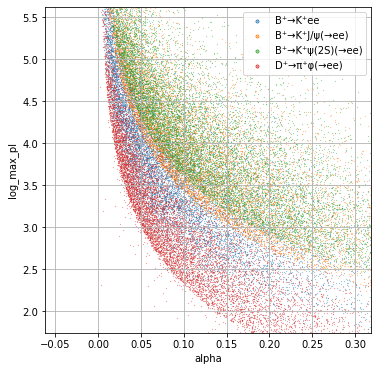

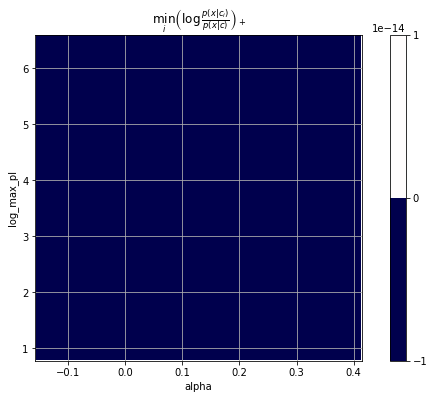

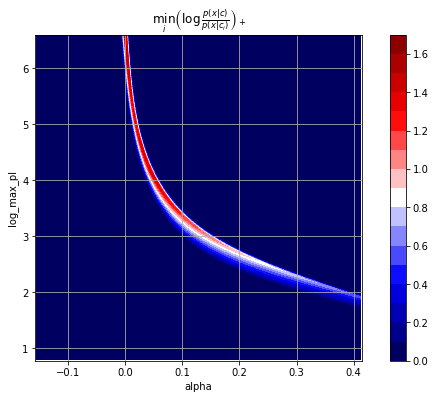

In [43]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

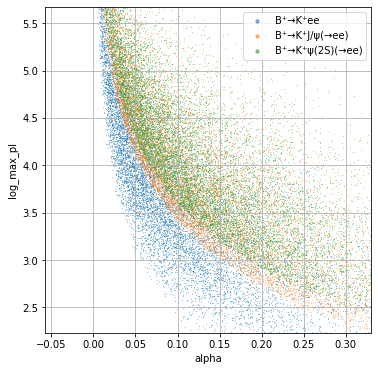

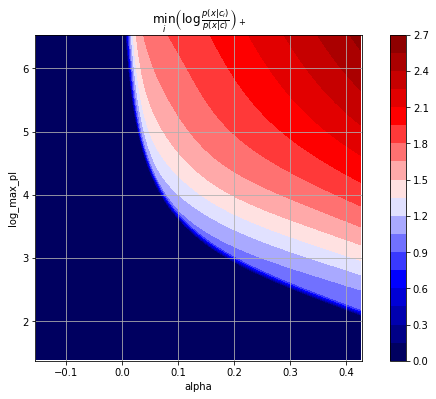

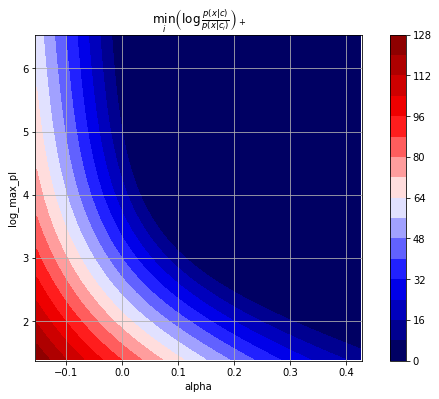

In [44]:
plot_ds(e_la3.ds)
plot_clf_min_max(e_la3.ds, e_la3.model)

In [45]:
%%time
e_ptpt = Estimator(["log_ep_PT", "log_em_PT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.389076
INFO:root:Epoch 1, 1.355785
INFO:root:Epoch 2, 1.274359
INFO:root:Epoch 3, 1.139735
INFO:root:Epoch 4, 1.097904
INFO:root:Epoch 5, 1.089334
INFO:root:Epoch 6, 1.082498
INFO:root:Epoch 7, 1.076550
INFO:root:Epoch 8, 1.071288
INFO:root:Epoch 9, 1.066667
INFO:root:Epoch 10, 1.062877
INFO:root:Epoch 11, 1.060022
INFO:root:Epoch 12, 1.058085
INFO:root:Epoch 13, 1.056747
INFO:root:Epoch 14, 1.055833
INFO:root:Epoch 15, 1.055130
INFO:root:Epoch 16, 1.054638
INFO:root:Epoch 17, 1.054245
INFO:root:Epoch 18, 1.053881
INFO:root:Epoch 19, 1.053518
INFO:root:Epoch 20, 1.053218
INFO:root:Epoch 21, 1.052917
INFO:root:Epoch 22, 1.052629
INFO:root:Epoch 23, 1.052308
INFO:root:Epoch 24, 1.051943
INFO:root:Epoch 25, 1.051573
INFO:root:Epoch 26, 1.051239
INFO:root:Epoch 27, 1.050889
INFO:root:Epoch 28, 1.050568
INFO:root:Epoch 29, 1.050194
INFO:root:Epoch 30, 1.049830
INFO:root:Epoch 31, 1.049418
INFO:root:Epoch 32, 1.048996
INFO:root:Epoch 33, 1.048652
INFO:root:Epoch 34, 1.04

CPU times: user 37.1 s, sys: 3.6 s, total: 40.7 s
Wall time: 40.5 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

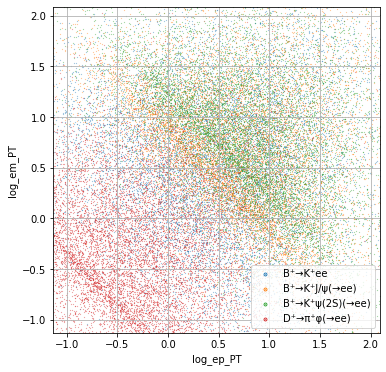

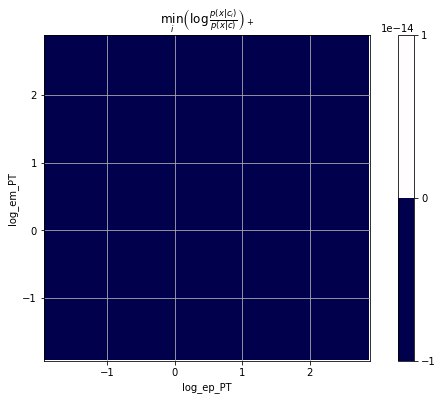

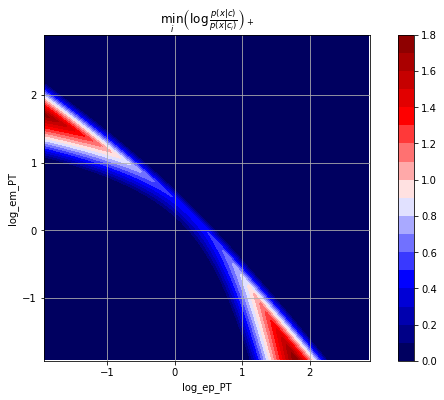

In [46]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [47]:
%%time
e_ptpt3 = Estimator(["log_ep_PT", "log_em_PT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.097034
INFO:root:Epoch 1, 1.090689
INFO:root:Epoch 2, 1.079630
INFO:root:Epoch 3, 1.065400
INFO:root:Epoch 4, 1.055429
INFO:root:Epoch 5, 1.047074
INFO:root:Epoch 6, 1.039518
INFO:root:Epoch 7, 1.032343
INFO:root:Epoch 8, 1.025566
INFO:root:Epoch 9, 1.019162
INFO:root:Epoch 10, 1.013543
INFO:root:Epoch 11, 1.009575
INFO:root:Epoch 12, 1.007743
INFO:root:Epoch 13, 1.007065
INFO:root:Epoch 14, 1.006682
INFO:root:Epoch 15, 1.006537
INFO:root:Epoch 16, 1.006173
INFO:root:Epoch 17, 1.005778
INFO:root:Epoch 18, 1.005483
INFO:root:Epoch 19, 1.005127
INFO:root:Epoch 20, 1.004819
INFO:root:Epoch 21, 1.004631
INFO:root:Epoch 22, 1.004178
INFO:root:Epoch 23, 1.003798
INFO:root:Epoch 24, 1.003471
INFO:root:Epoch 25, 1.003145
INFO:root:Epoch 26, 1.002715
INFO:root:Epoch 27, 1.002291
INFO:root:Epoch 28, 1.001943
INFO:root:Epoch 29, 1.001560
INFO:root:Epoch 30, 1.001429
INFO:root:Epoch 31, 1.000877
INFO:root:Epoch 32, 1.000515
INFO:root:Epoch 33, 0.999853
INFO:root:Epoch 34, 0.99

CPU times: user 27 s, sys: 1.99 s, total: 29 s
Wall time: 28.8 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

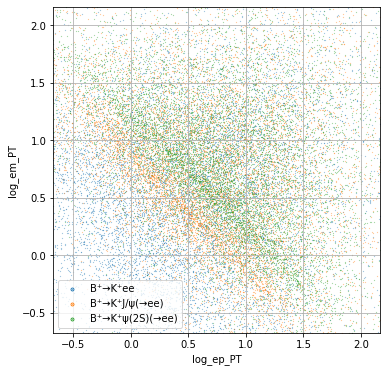

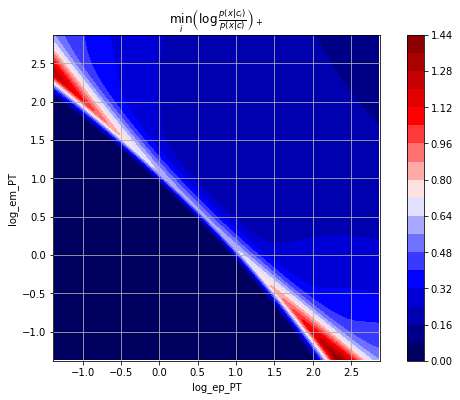

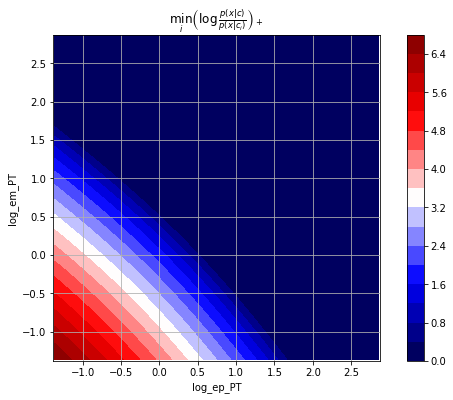

In [48]:
plot_ds(e_ptpt3.ds)
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model)

### Crafting a loss

In [49]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

In [50]:
def compute_lipschitz(model, loader, device=device):
    model.eval()
    k = torch.zeros(1, device=device)
    for batch in loader:
        x, y = batch
        x.to(device)
        x.requires_grad = True
        model.zero_grad()
        fx = model(x)
        loss = torch.sum(fx)
        loss.backward()
        k = torch.maximum(k, torch.max(x.grad.norm(dim=1)))
    return k.item()

In [51]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec, 0)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [52]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=-1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [53]:
@torch.no_grad()
def make_weighting(model, loader, selected_class, n_outs, n_classes):
    W = to_numpy(create_w(model, loader, n_outs, n_classes)[0])
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=-1), linear)

In [54]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001):
    res = torch.nn.Sequential(
        torch.nn.Sequential(
            model,
            torch.nn.Softmax(dim=-1),
        ),
        torch.nn.Linear(n_outs, 1, bias=False),
    ).to(device)
    tmp = clone_model(res)
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        model.eval()
        with torch.no_grad():
            W, counts = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        W_pinv_T = W_pinv_.T
        
        w0 = W_pinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0,0)
        m_sum = m_minus + m_plus        
        res[1].weight.data = from_numpy((w0 + m_minus)/m_sum).view(1, n_outs)
        L = compute_lipschitz(res, loader)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        W_m_t = from_numpy(W_m_)
        
        tmp.load_state_dict(res.state_dict())
        model.train()
        opt.zero_grad()
        total_loss = 0
        dx_ = torch.tensor([[[0]],[[-1]],[[1]]], dtype=torch.float, device=device)
        for batch in loader:
            x, y = batch
            
            x.requires_grad = True
            tmp.zero_grad()
            fx = tmp(x)
            L_loss = torch.sum(fx)
            L_loss.backward()
            dx = x.grad
            x.requires_grad = False
            ext_dx = dx[None,...] * dx_ # 3*B*n_features
            ext_x = x[None,...] + ext_dx*0.001
            
            y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
            pred3 = res[0](ext_x)  # 3*B*N
            pred = pred3[0]        #   B*N
            pred2 = pred3[1:3,...]
            pred_dfx = res[1](pred2) # 2*B*N
            dfx = (pred_dfx[1] - pred_dfx[0])*1000
            loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)
            
            wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
            W = wsum/counts
            
            loss_c = torch.sum(W*W_m_t)
            loss_d = -torch.sum(W*W_pinv_T)
            loss = loss_d + alpha * loss_c + loss_L
            total_loss += loss
            loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, total_loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det, L)
    res.eval()
    res.zero_grad(set_to_none=True)
    return res

In [55]:
class Weighting():
    def __init__(self, estimator):
        N = len(list(estimator.ds.indices))
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), N).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
        self.n_outs = N
        self.n_classes = N
    def train(self):
        self.w_model_ = None
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=100000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=500, alpha=300)
        return self.w_model()
    def w_model(self):
        if self.w_model_ is None:
            loader = Loader(self.estimator.ds.torch_dataset(), batch_size=100000, shuffle=False, device=device)
            self.w_model_ = make_weighting(self.model, loader, 0, self.n_outs, self.n_classes)
        return self.w_model_
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [56]:
%%time
w_la = Weighting(e_la)
w_la.train()

Epoch 0, loss=33.094139 est=0.228903 [ 4.7582 -4.3687  2.2538 -1.6351] 0.0066554407 4.948761940002441
Epoch 1, loss=20.917297 est=0.236701 [ 5.1617 -4.2247  1.8281 -1.5995] 0.0064374 4.721716403961182
Epoch 2, loss=12.496189 est=0.240135 [ 5.7197 -4.1643  1.5235 -1.5855] 0.0059702257 4.409967422485352
Epoch 3, loss=7.394566 est=0.235291 [ 6.4383 -4.2501  1.3422 -1.5749] 0.0053458195 4.0161285400390625
Epoch 4, loss=4.019851 est=0.223996 [ 7.3091 -4.4644  1.2465 -1.5587] 0.004700708 3.5765767097473145
Epoch 5, loss=1.551997 est=0.209358 [ 8.3252 -4.7765  1.2043 -1.5362] 0.004105805 3.2238247394561768
Epoch 6, loss=-0.258960 est=0.193665 [ 9.4829 -5.1635  1.1957 -1.5097] 0.0035839456 2.9489824771881104
Epoch 7, loss=-1.537028 est=0.178298 [10.7739 -5.6086  1.2085 -1.4818] 0.0031378316 2.688059091567993
Epoch 8, loss=-2.402209 est=0.164000 [12.1825 -6.0976  1.2346 -1.4543] 0.0027625924 2.448516607284546
Epoch 9, loss=-2.969586 est=0.151116 [13.6852 -6.6174  1.2682 -1.4285] 0.0024505095 2.

Epoch 79, loss=-3.465269 est=0.128162 [11.2029 -7.8026  0.2915 -1.3621] 0.0046074926 1.9156550168991089
Epoch 80, loss=-3.473531 est=0.127549 [11.2198 -7.8401  0.2859 -1.3615] 0.0046152873 1.9129760265350342
Epoch 81, loss=-3.481928 est=0.126942 [11.2375 -7.8776  0.2801 -1.3611] 0.0046221237 1.910128116607666
Epoch 82, loss=-3.490317 est=0.126347 [11.2552 -7.9147  0.2741 -1.361 ] 0.0046283547 1.9071426391601562
Epoch 83, loss=-3.498577 est=0.125767 [11.272  -7.9512  0.2678 -1.3612] 0.0046342704 1.9041224718093872
Epoch 84, loss=-3.506595 est=0.125206 [11.2872 -7.9869  0.2614 -1.3616] 0.0046401704 1.9011114835739136
Epoch 85, loss=-3.514286 est=0.124667 [11.3003 -8.0214  0.2548 -1.3624] 0.0046462864 1.8981776237487793
Epoch 86, loss=-3.521571 est=0.124152 [11.3106 -8.0546  0.248  -1.3635] 0.004652864 1.895370364189148
Epoch 87, loss=-3.528399 est=0.123664 [11.3179 -8.0864  0.2411 -1.3649] 0.0046600476 1.892684817314148
Epoch 88, loss=-3.534724 est=0.123203 [11.3217 -8.1167  0.2342 -1.36

Epoch 158, loss=-3.594672 est=0.103380 [ 8.8638 -9.6731  0.0276 -1.5033] 0.0057886834 1.8787548542022705
Epoch 159, loss=-3.595520 est=0.103131 [ 8.8294 -9.6964  0.0275 -1.5052] 0.005801703 1.8786734342575073
Epoch 160, loss=-3.596359 est=0.102886 [ 8.7952 -9.7195  0.0274 -1.507 ] 0.005814672 1.8785697221755981
Epoch 161, loss=-3.597191 est=0.102645 [ 8.7614 -9.7423  0.0274 -1.5088] 0.0058275955 1.8784345388412476
Epoch 162, loss=-3.598017 est=0.102409 [ 8.728  -9.7648  0.0275 -1.5106] 0.005840456 1.8782774209976196
Epoch 163, loss=-3.598834 est=0.102176 [ 8.6949 -9.787   0.0276 -1.5123] 0.005853273 1.8780955076217651
Epoch 164, loss=-3.599642 est=0.101948 [ 8.6622 -9.8089  0.0277 -1.5141] 0.0058660405 1.8778892755508423
Epoch 165, loss=-3.600441 est=0.101725 [ 8.6299 -9.8305  0.0279 -1.5158] 0.0058787586 1.8776620626449585
Epoch 166, loss=-3.601229 est=0.101506 [ 8.598  -9.8516  0.0282 -1.5175] 0.005891431 1.877413272857666
Epoch 167, loss=-3.602008 est=0.101292 [ 8.5665 -9.8725  0.02

Epoch 37, loss=-8.072701 est=0.917148 [19.8868 -0.787   0.1901 -1.0903] 0.006577653 2.3302085399627686
Epoch 38, loss=-7.958434 est=0.931458 [20.2974 -0.7664  0.192  -1.0736] 0.0064796363 2.318756341934204
Epoch 39, loss=-7.845035 est=0.944217 [20.7609 -0.7461  0.1922 -1.0591] 0.006371393 2.302459955215454
Epoch 40, loss=-7.733453 est=0.955165 [21.2674 -0.7254  0.1907 -1.0469] 0.0062572393 2.2821757793426514
Epoch 41, loss=-7.624559 est=0.964225 [21.8056 -0.7044  0.1875 -1.0371] 0.0061410386 2.2590620517730713
Epoch 42, loss=-7.519172 est=0.971495 [22.3641 -0.6829  0.183  -1.0293] 0.006026086 2.2342052459716797
Epoch 43, loss=-7.418077 est=0.977207 [22.9313 -0.6612  0.1776 -1.0233] 0.00591505 2.208829879760742
Epoch 44, loss=-7.321972 est=0.981690 [23.496  -0.6398  0.1716 -1.0187] 0.005810071 2.183844566345215
Epoch 45, loss=-7.231458 est=0.985317 [24.0475 -0.6189  0.1654 -1.0149] 0.005712773 2.1602096557617188
Epoch 46, loss=-7.146930 est=0.988476 [24.5764 -0.5988  0.1594 -1.0117] 0.0

Epoch 117, loss=-5.507156 est=1.228033 [35.5913 -0.2929  0.0717 -0.8143] 0.0046970556 2.050360918045044
Epoch 118, loss=-5.500335 est=1.229127 [35.6719 -0.2917  0.0711 -0.8136] 0.0046914336 2.0498440265655518
Epoch 119, loss=-5.493696 est=1.230173 [35.7502 -0.2906  0.0706 -0.8129] 0.0046860357 2.0493409633636475
Epoch 120, loss=-5.487241 est=1.231200 [35.8255 -0.2894  0.07   -0.8122] 0.0046809777 2.0489389896392822
Epoch 121, loss=-5.480977 est=1.232230 [35.8968 -0.2883  0.0695 -0.8115] 0.0046763434 2.0486767292022705
Epoch 122, loss=-5.474907 est=1.233279 [35.9639 -0.2873  0.0691 -0.8108] 0.0046721823 2.0485482215881348
Epoch 123, loss=-5.469022 est=1.234355 [36.0264 -0.2864  0.0686 -0.8101] 0.0046685394 2.048567771911621
Epoch 124, loss=-5.463317 est=1.235454 [36.0844 -0.2855  0.0682 -0.8094] 0.0046653887 2.0487477779388428
Epoch 125, loss=-5.457780 est=1.236569 [36.1382 -0.2846  0.0678 -0.8087] 0.004662707 2.049071788787842
Epoch 126, loss=-5.452397 est=1.237686 [36.1882 -0.2838  0.

Epoch 196, loss=-5.277144 est=1.270083 [37.8556 -0.2485  0.0506 -0.7873] 0.0046188557 2.050262928009033
Epoch 197, loss=-5.276354 est=1.270220 [37.8605 -0.2482  0.0505 -0.7873] 0.004619554 2.050092935562134
Epoch 198, loss=-5.275593 est=1.270352 [37.8651 -0.2479  0.0503 -0.7872] 0.0046202876 2.0499279499053955
Epoch 199, loss=-5.274851 est=1.270482 [37.8693 -0.2476  0.0502 -0.7871] 0.0046210475 2.0497641563415527
Epoch 200, loss=-5.274129 est=1.270609 [37.8731 -0.2473  0.0501 -0.787 ] 0.0046218373 2.049604892730713
Epoch 201, loss=-5.273432 est=1.270731 [37.8766 -0.2471  0.05   -0.7869] 0.0046226494 2.04946231842041
Epoch 202, loss=-5.272753 est=1.270850 [37.8798 -0.2468  0.0499 -0.7869] 0.0046234787 2.0493171215057373
Epoch 203, loss=-5.272093 est=1.270963 [37.8828 -0.2465  0.0498 -0.7868] 0.004624325 2.04917049407959
Epoch 204, loss=-5.271452 est=1.271071 [37.8856 -0.2463  0.0497 -0.7867] 0.004625182 2.0490212440490723
Epoch 205, loss=-5.270829 est=1.271177 [37.8882 -0.246   0.0495 -

Epoch 275, loss=-5.251460 est=1.274535 [37.8112 -0.2331  0.044  -0.7846] 0.004696767 2.033714532852173
Epoch 276, loss=-5.251357 est=1.274561 [37.8083 -0.2329  0.0439 -0.7846] 0.004697784 2.0334596633911133
Epoch 277, loss=-5.251260 est=1.274587 [37.8054 -0.2328  0.0438 -0.7846] 0.0046987957 2.033207416534424
Epoch 278, loss=-5.251159 est=1.274613 [37.8025 -0.2327  0.0438 -0.7846] 0.004699811 2.0329525470733643
Epoch 279, loss=-5.251066 est=1.274638 [37.7996 -0.2325  0.0437 -0.7845] 0.0047008237 2.0326943397521973
Epoch 280, loss=-5.250973 est=1.274665 [37.7966 -0.2324  0.0437 -0.7845] 0.004701839 2.0324363708496094
Epoch 281, loss=-5.250883 est=1.274690 [37.7936 -0.2323  0.0436 -0.7845] 0.0047028475 2.0321760177612305
Epoch 282, loss=-5.250794 est=1.274715 [37.7906 -0.2321  0.0436 -0.7845] 0.0047038547 2.031914710998535
Epoch 283, loss=-5.250711 est=1.274740 [37.7876 -0.232   0.0435 -0.7845] 0.0047048572 2.031651735305786
Epoch 284, loss=-5.250629 est=1.274765 [37.7846 -0.2319  0.0434

Epoch 354, loss=-5.251099 est=1.275974 [37.5091 -0.2249  0.0402 -0.7837] 0.00477606 2.010530948638916
Epoch 355, loss=-5.251205 est=1.275980 [37.504  -0.2249  0.0401 -0.7837] 0.0047771195 2.010195255279541
Epoch 356, loss=-5.251314 est=1.275986 [37.4989 -0.2248  0.0401 -0.7837] 0.0047781775 2.009854555130005
Epoch 357, loss=-5.251428 est=1.275990 [37.4937 -0.2247  0.0401 -0.7837] 0.00477924 2.0095162391662598
Epoch 358, loss=-5.251544 est=1.275995 [37.4885 -0.2246  0.04   -0.7837] 0.0047803065 2.0091776847839355
Epoch 359, loss=-5.251662 est=1.275999 [37.4832 -0.2246  0.04   -0.7837] 0.004781376 2.0088326930999756
Epoch 360, loss=-5.251783 est=1.276003 [37.4778 -0.2245  0.0399 -0.7837] 0.004782458 2.008493423461914
Epoch 361, loss=-5.251912 est=1.276006 [37.4724 -0.2244  0.0399 -0.7837] 0.00478354 2.008145809173584
Epoch 362, loss=-5.252038 est=1.276008 [37.467  -0.2243  0.0399 -0.7837] 0.004784628 2.007800579071045
Epoch 363, loss=-5.252172 est=1.276010 [37.4615 -0.2243  0.0398 -0.783

Epoch 433, loss=-5.270966 est=1.274844 [36.9373 -0.2202  0.0378 -0.7844] 0.004875872 1.9793462753295898
Epoch 434, loss=-5.271379 est=1.274808 [36.9275 -0.2202  0.0378 -0.7844] 0.0048774118 1.9788821935653687
Epoch 435, loss=-5.271796 est=1.274771 [36.9177 -0.2202  0.0378 -0.7845] 0.0048789526 1.9784148931503296
Epoch 436, loss=-5.272217 est=1.274734 [36.9079 -0.2201  0.0378 -0.7845] 0.0048805047 1.9779618978500366
Epoch 437, loss=-5.272643 est=1.274697 [36.8979 -0.2201  0.0377 -0.7845] 0.004882066 1.9775046110153198
Epoch 438, loss=-5.273071 est=1.274660 [36.8879 -0.22    0.0377 -0.7845] 0.004883631 1.977044701576233
Epoch 439, loss=-5.273506 est=1.274621 [36.8779 -0.22    0.0377 -0.7845] 0.0048852023 1.9765820503234863
Epoch 440, loss=-5.273942 est=1.274583 [36.8678 -0.2199  0.0377 -0.7846] 0.004886787 1.9761203527450562
Epoch 441, loss=-5.274382 est=1.274544 [36.8576 -0.2199  0.0376 -0.7846] 0.0048883758 1.9756571054458618
Epoch 442, loss=-5.274828 est=1.274505 [36.8473 -0.2199  0.0

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [57]:
%%time
w_la3 = Weighting(e_la3)
w_la3.train()

Epoch 0, loss=62.233528 est=0.496184 [ 1.8854 -2.0154  1.1348] 0.02379835 4.818689823150635
Epoch 1, loss=43.750355 est=0.525554 [ 1.9378 -1.9028  0.9601] 0.023143785 4.7972412109375
Epoch 2, loss=30.611284 est=0.546046 [ 2.0006 -1.8313  0.8291] 0.021919003 4.7871479988098145
Epoch 3, loss=23.012127 est=0.554041 [ 2.0706 -1.8049  0.7397] 0.020300452 4.771907329559326
Epoch 4, loss=18.646296 est=0.549083 [ 2.1428 -1.8212  0.6856] 0.018534588 4.736517429351807
Epoch 5, loss=15.680358 est=0.534503 [ 2.2141 -1.8709  0.6565] 0.016822455 4.680045127868652
Epoch 6, loss=13.344416 est=0.513994 [ 2.2828 -1.9455  0.6444] 0.015258583 4.6061248779296875
Epoch 7, loss=11.371942 est=0.490390 [ 2.3484 -2.0392  0.6442] 0.013870842 4.519024848937988
Epoch 8, loss=9.660499 est=0.465627 [ 2.4104 -2.1476  0.6525] 0.012656321 4.421773433685303
Epoch 9, loss=8.161377 est=0.440938 [ 2.4687 -2.2679  0.6671] 0.01159975 4.316178798675537
Epoch 10, loss=6.847107 est=0.417074 [ 2.5235 -2.3977  0.6865] 0.010682337

Epoch 87, loss=-2.418974 est=0.172999 [ 2.5083 -5.7804  0.8261] 0.008867321 2.02608060836792
Epoch 88, loss=-2.422103 est=0.173077 [ 2.5033 -5.7778  0.8196] 0.008944629 2.022549867630005
Epoch 89, loss=-2.425234 est=0.173159 [ 2.4984 -5.775   0.8131] 0.009021675 2.0185794830322266
Epoch 90, loss=-2.428356 est=0.173244 [ 2.4936 -5.7722  0.8066] 0.009098532 2.0152361392974854
Epoch 91, loss=-2.431480 est=0.173333 [ 2.4889 -5.7692  0.8001] 0.0091751795 2.011760711669922
Epoch 92, loss=-2.434604 est=0.173426 [ 2.4843 -5.7662  0.7937] 0.009251662 2.0078465938568115
Epoch 93, loss=-2.437718 est=0.173523 [ 2.4798 -5.7629  0.7872] 0.009328033 2.0034985542297363
Epoch 94, loss=-2.440830 est=0.173624 [ 2.4753 -5.7596  0.7807] 0.009404286 1.9998843669891357
Epoch 95, loss=-2.443938 est=0.173729 [ 2.471  -5.7561  0.7743] 0.009480454 1.9965897798538208
Epoch 96, loss=-2.447038 est=0.173838 [ 2.4667 -5.7525  0.7678] 0.009556567 1.9943714141845703
Epoch 97, loss=-2.450126 est=0.173952 [ 2.4625 -5.748

Epoch 173, loss=-2.574078 est=0.191315 [ 2.2572 -5.227   0.3889] 0.015942475 1.8757495880126953
Epoch 174, loss=-2.574477 est=0.191563 [ 2.2556 -5.2202  0.3857] 0.016026888 1.8768221139907837
Epoch 175, loss=-2.574859 est=0.191809 [ 2.254  -5.2135  0.3825] 0.016111046 1.877935528755188
Epoch 176, loss=-2.575229 est=0.192054 [ 2.2524 -5.2069  0.3794] 0.01619486 1.8790428638458252
Epoch 177, loss=-2.575581 est=0.192297 [ 2.2508 -5.2003  0.3763] 0.016278436 1.8801772594451904
Epoch 178, loss=-2.575918 est=0.192538 [ 2.2493 -5.1938  0.3732] 0.016361663 1.8813908100128174
Epoch 179, loss=-2.576243 est=0.192778 [ 2.2478 -5.1873  0.3702] 0.016444562 1.8825806379318237
Epoch 180, loss=-2.576552 est=0.193016 [ 2.2463 -5.1809  0.3672] 0.01652714 1.8837542533874512
Epoch 181, loss=-2.576849 est=0.193253 [ 2.2449 -5.1746  0.3642] 0.01660938 1.8849834203720093
Epoch 182, loss=-2.577131 est=0.193487 [ 2.2435 -5.1683  0.3613] 0.016691282 1.8862522840499878
Epoch 183, loss=-2.577400 est=0.193721 [ 2.2

Epoch 60, loss=-2.008645 est=12.721461 [10.4757 -0.0786 -0.0039] 0.014278754 3.5290145874023438
Epoch 61, loss=-2.016279 est=13.245240 [10.7383 -0.0755 -0.0032] 0.013998893 3.509650468826294
Epoch 62, loss=-2.024076 est=13.749743 [10.981  -0.0727 -0.0024] 0.013755232 3.5023677349090576
Epoch 63, loss=-2.031905 est=14.231705 [11.2011 -0.0703 -0.0017] 0.013547396 3.4898290634155273
Epoch 64, loss=-2.039638 est=14.688536 [11.3965 -0.0681 -0.0009] 0.013374706 3.4794485569000244
Epoch 65, loss=-2.047178 est=15.117850 [11.5653 -0.0661 -0.0002] 0.013236167 3.462162971496582
Epoch 66, loss=-1.587678 est=15.517677 [11.7065 -0.0644  0.0006] 0.013130526 3.444138765335083
Epoch 67, loss=-1.620591 est=15.874287 [11.8512 -0.063   0.0013] 0.01302226 3.4359655380249023
Epoch 68, loss=-1.655382 est=16.189348 [11.9963 -0.0618  0.0018] 0.012915353 3.4240942001342773
Epoch 69, loss=-1.691188 est=16.464554 [12.1383 -0.0607  0.0023] 0.012813475 3.4122819900512695
Epoch 70, loss=-1.727293 est=16.701126 [12.2

Epoch 146, loss=-2.387824 est=14.795454 [10.7617 -0.0676  0.011 ] 0.01710713 2.7073891162872314
Epoch 147, loss=-2.390312 est=14.788672 [10.7599 -0.0676  0.011 ] 0.017126381 2.704603433609009
Epoch 148, loss=-2.392737 est=14.782209 [10.7579 -0.0676  0.011 ] 0.017145619 2.7018685340881348
Epoch 149, loss=-2.395086 est=14.776064 [10.7555 -0.0677  0.011 ] 0.017165003 2.699185848236084
Epoch 150, loss=-2.397360 est=14.770054 [10.7528 -0.0677  0.011 ] 0.017184699 2.6965551376342773
Epoch 151, loss=-2.399550 est=14.764205 [10.7496 -0.0677  0.011 ] 0.01720481 2.693979263305664
Epoch 152, loss=-2.401658 est=14.758491 [10.746  -0.0678  0.011 ] 0.017225396 2.6914572715759277
Epoch 153, loss=-2.403680 est=14.752884 [10.7418 -0.0678  0.011 ] 0.01724649 2.688988447189331
Epoch 154, loss=-2.405619 est=14.747438 [10.7371 -0.0678  0.011 ] 0.017268086 2.686573028564453
Epoch 155, loss=-2.407480 est=14.742099 [10.732  -0.0678  0.011 ] 0.017290128 2.6842079162597656
Epoch 156, loss=-2.409266 est=14.73691

Epoch 232, loss=-2.472753 est=15.170892 [10.5447 -0.0659  0.0115] 0.018220304 2.5632717609405518
Epoch 233, loss=-2.473213 est=15.179237 [10.5436 -0.0659  0.0115] 0.01822647 2.562074899673462
Epoch 234, loss=-2.473670 est=15.187564 [10.5426 -0.0658  0.0115] 0.018232547 2.5608839988708496
Epoch 235, loss=-2.474127 est=15.195873 [10.5416 -0.0658  0.0115] 0.01823852 2.559697389602661
Epoch 236, loss=-2.474576 est=15.204218 [10.5406 -0.0658  0.0115] 0.018244425 2.5585172176361084
Epoch 237, loss=-2.475024 est=15.212517 [10.5396 -0.0657  0.0115] 0.018250223 2.557340383529663
Epoch 238, loss=-2.475472 est=15.220770 [10.5386 -0.0657  0.0115] 0.018255971 2.5561704635620117
Epoch 239, loss=-2.475916 est=15.229005 [10.5377 -0.0657  0.0115] 0.018261647 2.555004119873047
Epoch 240, loss=-2.476356 est=15.237221 [10.5367 -0.0656  0.0115] 0.01826726 2.553844928741455
Epoch 241, loss=-2.476785 est=15.245501 [10.5357 -0.0656  0.0115] 0.018272828 2.5526907444000244
Epoch 242, loss=-2.477219 est=15.25362

Epoch 318, loss=-2.504397 est=15.802308 [10.4756 -0.0633  0.0117] 0.01856474 2.484675168991089
Epoch 319, loss=-2.504718 est=15.808592 [10.4749 -0.0633  0.0117] 0.018567355 2.483949661254883
Epoch 320, loss=-2.505034 est=15.814940 [10.4742 -0.0632  0.0117] 0.018569954 2.483227252960205
Epoch 321, loss=-2.505360 est=15.821055 [10.4735 -0.0632  0.0117] 0.01857253 2.4825079441070557
Epoch 322, loss=-2.505677 est=15.827383 [10.4728 -0.0632  0.0117] 0.01857509 2.4817912578582764
Epoch 323, loss=-2.505995 est=15.833597 [10.4721 -0.0632  0.0117] 0.018577628 2.481077194213867
Epoch 324, loss=-2.506313 est=15.839846 [10.4714 -0.0631  0.0117] 0.018580154 2.480365753173828
Epoch 325, loss=-2.506629 est=15.846069 [10.4707 -0.0631  0.0118] 0.018582651 2.47965669631958
Epoch 326, loss=-2.506953 est=15.852118 [10.4701 -0.0631  0.0118] 0.018585142 2.478949785232544
Epoch 327, loss=-2.507267 est=15.858321 [10.4694 -0.0631  0.0118] 0.01858762 2.4782462120056152
Epoch 328, loss=-2.507590 est=15.864380 [1

Epoch 404, loss=-2.531530 est=16.293811 [10.4127 -0.0614  0.012 ] 0.018751102 2.4404733180999756
Epoch 405, loss=-2.531840 est=16.299193 [10.4119 -0.0614  0.012 ] 0.018753095 2.440021514892578
Epoch 406, loss=-2.532144 est=16.304706 [10.4111 -0.0613  0.012 ] 0.018755088 2.439568519592285
Epoch 407, loss=-2.532456 est=16.310063 [10.4102 -0.0613  0.012 ] 0.018757075 2.439115524291992
Epoch 408, loss=-2.532762 est=16.315519 [10.4094 -0.0613  0.012 ] 0.018759063 2.438662052154541
Epoch 409, loss=-2.533070 est=16.320948 [10.4086 -0.0613  0.012 ] 0.018761063 2.4382081031799316
Epoch 410, loss=-2.533372 est=16.326443 [10.4077 -0.0613  0.012 ] 0.01876305 2.437753438949585
Epoch 411, loss=-2.533683 est=16.331783 [10.4069 -0.0612  0.012 ] 0.018765042 2.4372987747192383
Epoch 412, loss=-2.533985 est=16.337286 [10.4061 -0.0612  0.012 ] 0.018767051 2.4368438720703125
Epoch 413, loss=-2.534293 est=16.342633 [10.4052 -0.0612  0.012 ] 0.018769061 2.4363884925842285
Epoch 414, loss=-2.534589 est=16.348

Epoch 490, loss=-2.553364 est=16.782922 [10.3358 -0.0596  0.012 ] 0.018928967 2.4355204105377197
Epoch 491, loss=-2.553547 est=16.788834 [10.3349 -0.0596  0.012 ] 0.018931087 2.435647487640381
Epoch 492, loss=-2.553719 est=16.794884 [10.334  -0.0595  0.012 ] 0.018933218 2.435772180557251
Epoch 493, loss=-2.553892 est=16.800939 [10.3331 -0.0595  0.012 ] 0.018935328 2.435892343521118
Epoch 494, loss=-2.554066 est=16.806964 [10.3322 -0.0595  0.012 ] 0.018937435 2.436009645462036
Epoch 495, loss=-2.554245 est=16.812859 [10.3313 -0.0595  0.012 ] 0.018939542 2.4361233711242676
Epoch 496, loss=-2.554414 est=16.818927 [10.3304 -0.0595  0.012 ] 0.018941658 2.436234712600708
Epoch 497, loss=-2.554584 est=16.824932 [10.3295 -0.0594  0.012 ] 0.018943755 2.4363417625427246
Epoch 498, loss=-2.554747 est=16.831008 [10.3286 -0.0594  0.012 ] 0.018945863 2.4364469051361084
Epoch 499, loss=-2.554919 est=16.836954 [10.3278 -0.0594  0.012 ] 0.018947951 2.4365479946136475
[[0.1007 0.0017 0.0003]
 [0.7168 0.

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [58]:
%%time
w_ptpt = Weighting(e_ptpt)
w_ptpt.train()

Epoch 0, loss=-3.999960 est=0.093733 [ 14.9742 -10.6686   0.0531  -3.375 ] 0.0011229421 0.8416543006896973
Epoch 1, loss=-3.999723 est=0.105659 [13.2814 -9.4644  0.2448 -3.8449] 0.0013017496 0.8941493034362793
Epoch 2, loss=-3.999179 est=0.118293 [12.0197 -8.4536  0.3431 -4.348 ] 0.001464649 0.9416235089302063
Epoch 3, loss=-3.998254 est=0.130960 [11.1225 -7.6359  0.3767 -4.8294] 0.0016089389 0.9825840592384338
Epoch 4, loss=-3.997023 est=0.143138 [10.5514 -6.9863  0.3553 -5.1913] 0.0017416102 1.0146697759628296
Epoch 5, loss=-3.995682 est=0.154443 [10.2419 -6.4749  0.2933 -5.3606] 0.0018735381 1.0367964506149292
Epoch 6, loss=-3.994404 est=0.164643 [10.1203 -6.0737  0.2094 -5.3373] 0.0020109147 1.0520063638687134
Epoch 7, loss=-3.993222 est=0.173549 [10.1115 -5.7621  0.1263 -5.176 ] 0.0021539498 1.0624629259109497
Epoch 8, loss=-3.991977 est=0.181102 [10.1507 -5.5218  0.0615 -4.9436] 0.0023006513 1.0707478523254395
Epoch 9, loss=-3.990352 est=0.187388 [10.1795 -5.3365  0.027  -4.6953]

Epoch 80, loss=-3.764368 est=0.281525 [ 7.6558 -2.2615  0.1257 -3.5521] 0.009875166 1.2860559225082397
Epoch 81, loss=-3.764508 est=0.281382 [ 7.6503 -2.2604  0.1248 -3.5539] 0.009903132 1.2849843502044678
Epoch 82, loss=-3.764561 est=0.281737 [ 7.6566 -2.2597  0.1239 -3.5494] 0.009927239 1.283964991569519
Epoch 83, loss=-3.764635 est=0.282484 [ 7.6728 -2.2592  0.1231 -3.54  ] 0.009947744 1.2828798294067383
Epoch 84, loss=-3.764793 est=0.283425 [ 7.6942 -2.2588  0.1223 -3.5283] 0.00996577 1.2816526889801025
Epoch 85, loss=-3.765051 est=0.284319 [ 7.7149 -2.2584  0.1215 -3.5172] 0.009983036 1.2802720069885254
Epoch 86, loss=-3.765373 est=0.284953 [ 7.7291 -2.2581  0.1209 -3.5093] 0.010001368 1.2787803411483765
Epoch 87, loss=-3.765719 est=0.285195 [ 7.7332 -2.2579  0.1203 -3.5064] 0.010022059 1.2772233486175537
Epoch 88, loss=-3.766089 est=0.285023 [ 7.7266 -2.2576  0.1198 -3.5085] 0.010045335 1.2756069898605347
Epoch 89, loss=-3.766519 est=0.284526 [ 7.712  -2.2574  0.1194 -3.5146] 0.0

Epoch 160, loss=-3.756080 est=0.285298 [ 7.4308 -2.4067  0.1005 -3.5051] 0.010913162 1.232436180114746
Epoch 161, loss=-3.755386 est=0.285365 [ 7.4266 -2.4152  0.1003 -3.5043] 0.0109128235 1.2324820756912231
Epoch 162, loss=-3.754664 est=0.285414 [ 7.4219 -2.4242  0.1001 -3.5037] 0.010912089 1.2325125932693481
Epoch 163, loss=-3.753918 est=0.285450 [ 7.4169 -2.4335  0.0999 -3.5032] 0.01091089 1.2325350046157837
Epoch 164, loss=-3.753147 est=0.285484 [ 7.4118 -2.4432  0.0996 -3.5028] 0.010909133 1.2325608730316162
Epoch 165, loss=-3.752350 est=0.285527 [ 7.4068 -2.4534  0.0994 -3.5023] 0.010906727 1.232605218887329
Epoch 166, loss=-3.751523 est=0.285585 [ 7.4022 -2.4641  0.0992 -3.5016] 0.010903617 1.2326774597167969
Epoch 167, loss=-3.750655 est=0.285658 [ 7.3977 -2.4753  0.099  -3.5007] 0.010899815 1.2327759265899658
Epoch 168, loss=-3.749747 est=0.285740 [ 7.3933 -2.4871  0.0987 -3.4997] 0.010895292 1.2328941822052002
Epoch 169, loss=-3.748793 est=0.285823 [ 7.3888 -2.4995  0.0985 -3

Epoch 39, loss=-11.619205 est=0.542655 [22.3879 -1.5045  0.0996 -1.8428] 0.0058458704 1.6303356885910034
Epoch 40, loss=-11.407069 est=0.544070 [22.9593 -1.4885  0.098  -1.838 ] 0.0057250406 1.629584789276123
Epoch 41, loss=-11.229051 est=0.545792 [23.4501 -1.4749  0.0967 -1.8322] 0.005626234 1.6336512565612793
Epoch 42, loss=-11.085196 est=0.547742 [23.8458 -1.4634  0.0956 -1.8257] 0.005550461 1.641063928604126
Epoch 43, loss=-10.974061 est=0.549854 [24.1389 -1.4536  0.0948 -1.8187] 0.0054975334 1.65226411819458
Epoch 44, loss=-10.892909 est=0.552078 [24.3292 -1.4453  0.0943 -1.8113] 0.005466176 1.6673009395599365
Epoch 45, loss=-10.837947 est=0.554383 [24.424  -1.4382  0.0939 -1.8038] 0.0054541663 1.6858638525009155
Epoch 46, loss=-10.804522 est=0.556754 [24.4368 -1.4323  0.0936 -1.7961] 0.005458458 1.7073618173599243
Epoch 47, loss=-10.787339 est=0.559193 [24.3859 -1.4273  0.0935 -1.7883] 0.005475342 1.7309826612472534
Epoch 48, loss=-10.780759 est=0.561711 [24.2925 -1.4233  0.0935 

Epoch 119, loss=-8.843875 est=0.612019 [31.0405 -1.2668  0.0892 -1.6339] 0.0044819447 2.067780017852783
Epoch 120, loss=-8.836301 est=0.612147 [31.0793 -1.2658  0.0891 -1.6336] 0.0044774567 2.0688278675079346
Epoch 121, loss=-8.829401 est=0.612240 [31.1138 -1.2648  0.0889 -1.6333] 0.0044735624 2.0699236392974854
Epoch 122, loss=-8.823053 est=0.612308 [31.1446 -1.2638  0.0888 -1.6332] 0.004470156 2.0710573196411133
Epoch 123, loss=-8.817109 est=0.612362 [31.1728 -1.2627  0.0887 -1.633 ] 0.004467089 2.072211980819702
Epoch 124, loss=-8.811398 est=0.612416 [31.1998 -1.2617  0.0886 -1.6329] 0.004464179 2.073359489440918
Epoch 125, loss=-8.805753 est=0.612481 [31.2268 -1.2608  0.0884 -1.6327] 0.004461276 2.074472188949585
Epoch 126, loss=-8.800058 est=0.612566 [31.2545 -1.2599  0.0883 -1.6325] 0.0044582463 2.0755324363708496
Epoch 127, loss=-8.794212 est=0.612678 [31.2837 -1.259   0.0882 -1.6322] 0.0044550113 2.076524496078491
Epoch 128, loss=-8.788189 est=0.612820 [31.3147 -1.2583  0.0881 

Epoch 198, loss=-8.584887 est=0.623361 [32.3506 -1.2334  0.0835 -1.6042] 0.004351364 2.1204559803009033
Epoch 199, loss=-8.583765 est=0.623480 [32.3556 -1.2332  0.0835 -1.6039] 0.004351116 2.120668888092041
Epoch 200, loss=-8.582656 est=0.623601 [32.3605 -1.233   0.0834 -1.6036] 0.00435088 2.120873212814331
Epoch 201, loss=-8.581567 est=0.623721 [32.3654 -1.2328  0.0833 -1.6033] 0.0043506455 2.121065616607666
Epoch 202, loss=-8.580485 est=0.623841 [32.3702 -1.2325  0.0833 -1.603 ] 0.00435042 2.121248722076416
Epoch 203, loss=-8.579431 est=0.623962 [32.3749 -1.2323  0.0832 -1.6027] 0.0043501994 2.1214241981506348
Epoch 204, loss=-8.578387 est=0.624084 [32.3795 -1.2321  0.0832 -1.6023] 0.004349996 2.1215932369232178
Epoch 205, loss=-8.577371 est=0.624206 [32.3839 -1.2319  0.0831 -1.602 ] 0.004349809 2.121756076812744
Epoch 206, loss=-8.576379 est=0.624328 [32.3882 -1.2317  0.083  -1.6017] 0.004349639 2.1219141483306885
Epoch 207, loss=-8.575415 est=0.624450 [32.3923 -1.2315  0.083  -1.60

Epoch 277, loss=-8.547215 est=0.633177 [32.4197 -1.2205  0.0792 -1.5793] 0.0043683746 2.1874277591705322
Epoch 278, loss=-8.547203 est=0.633309 [32.4174 -1.2204  0.0792 -1.579 ] 0.004368953 2.188814640045166
Epoch 279, loss=-8.547202 est=0.633441 [32.415  -1.2203  0.0791 -1.5787] 0.0043695373 2.190185070037842
Epoch 280, loss=-8.547210 est=0.633574 [32.4125 -1.2202  0.0791 -1.5783] 0.0043701273 2.1915323734283447
Epoch 281, loss=-8.547224 est=0.633707 [32.41  -1.22   0.079 -1.578] 0.00437073 2.1928656101226807
Epoch 282, loss=-8.547252 est=0.633840 [32.4074 -1.2199  0.079  -1.5777] 0.004371337 2.194175958633423
Epoch 283, loss=-8.547284 est=0.633973 [32.4047 -1.2198  0.0789 -1.5774] 0.004371951 2.195467948913574
Epoch 284, loss=-8.547321 est=0.634107 [32.402  -1.2197  0.0789 -1.577 ] 0.0043725753 2.1967408657073975
Epoch 285, loss=-8.547365 est=0.634242 [32.3992 -1.2196  0.0788 -1.5767] 0.004373203 2.197993040084839
Epoch 286, loss=-8.547417 est=0.634376 [32.3965 -1.2195  0.0788 -1.576

Epoch 356, loss=-8.562357 est=0.644895 [32.099  -1.2129  0.0753 -1.5506] 0.00442978 2.273707389831543
Epoch 357, loss=-8.562651 est=0.645064 [32.0938 -1.2129  0.0753 -1.5502] 0.004430692 2.274566411972046
Epoch 358, loss=-8.562933 est=0.645234 [32.0886 -1.2128  0.0752 -1.5498] 0.0044316077 2.2754056453704834
Epoch 359, loss=-8.563226 est=0.645405 [32.0834 -1.2127  0.0752 -1.5494] 0.0044325194 2.2762258052825928
Epoch 360, loss=-8.563514 est=0.645576 [32.0781 -1.2126  0.0751 -1.549 ] 0.004433437 2.2770326137542725
Epoch 361, loss=-8.563803 est=0.645748 [32.0729 -1.2126  0.0751 -1.5486] 0.0044343527 2.2780802249908447
Epoch 362, loss=-8.564091 est=0.645920 [32.0677 -1.2125  0.075  -1.5482] 0.004435267 2.2791056632995605
Epoch 363, loss=-8.564377 est=0.646093 [32.0624 -1.2124  0.075  -1.5478] 0.004436188 2.2801096439361572
Epoch 364, loss=-8.564662 est=0.646267 [32.0571 -1.2123  0.0749 -1.5473] 0.004437114 2.281094551086426
Epoch 365, loss=-8.564956 est=0.646442 [32.0517 -1.2123  0.0749 -

Epoch 435, loss=-8.576765 est=0.660443 [31.692  -1.2079  0.0712 -1.5141] 0.0045011826 2.3238232135772705
Epoch 436, loss=-8.576729 est=0.660671 [31.6876 -1.2078  0.0712 -1.5136] 0.004501995 2.3242554664611816
Epoch 437, loss=-8.576680 est=0.660899 [31.6831 -1.2078  0.0711 -1.5131] 0.004502803 2.324662446975708
Epoch 438, loss=-8.576624 est=0.661128 [31.6788 -1.2077  0.0711 -1.5126] 0.0045036064 2.325042486190796
Epoch 439, loss=-8.576562 est=0.661359 [31.6744 -1.2077  0.071  -1.512 ] 0.0045044026 2.325397253036499
Epoch 440, loss=-8.576490 est=0.661590 [31.6701 -1.2076  0.071  -1.5115] 0.004505198 2.3257253170013428
Epoch 441, loss=-8.576409 est=0.661821 [31.6658 -1.2076  0.0709 -1.511 ] 0.004505987 2.3260250091552734
Epoch 442, loss=-8.576317 est=0.662054 [31.6616 -1.2075  0.0708 -1.5105] 0.004506765 2.3262991905212402
Epoch 443, loss=-8.576216 est=0.662288 [31.6574 -1.2075  0.0708 -1.5099] 0.004507542 2.3265457153320312
Epoch 444, loss=-8.576102 est=0.662522 [31.6533 -1.2074  0.0707 

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [59]:
%%time
w_ptpt3 = Weighting(e_ptpt3)
w_ptpt3.train()

Epoch 0, loss=-3.000060 est=0.216021 [ 4.9232 -4.6292  0.7161] 0.007112215 0.7116718888282776
Epoch 1, loss=-2.999918 est=0.228307 [ 4.8381 -4.3801  0.6715] 0.007889576 0.7478907108306885
Epoch 2, loss=-2.999317 est=0.242246 [ 4.7964 -4.128   0.6015] 0.00860853 0.7785791158676147
Epoch 3, loss=-2.998298 est=0.256969 [ 4.7796 -3.8915  0.5239] 0.009278201 0.8041836619377136
Epoch 4, loss=-2.996943 est=0.271902 [ 4.7749 -3.6778  0.4493] 0.009908078 0.8255893588066101
Epoch 5, loss=-2.995257 est=0.286451 [ 4.7713 -3.491   0.3858] 0.01050885 0.8445947170257568
Epoch 6, loss=-2.993131 est=0.300176 [ 4.761  -3.3314  0.3372] 0.01109244 0.8631266355514526
Epoch 7, loss=-2.990407 est=0.312889 [ 4.7406 -3.196   0.3031] 0.011670192 0.8822640180587769
Epoch 8, loss=-2.986925 est=0.324656 [ 4.7108 -3.0802  0.2806] 0.012250981 0.9025353789329529
Epoch 9, loss=-2.982594 est=0.335768 [ 4.6754 -2.9782  0.2648] 0.01284026 0.923679530620575
Epoch 10, loss=-2.977464 est=0.346692 [ 4.6397 -2.8844  0.2509] 0

Epoch 87, loss=-2.855552 est=0.803389 [ 4.6592 -1.2447  0.0572] 0.03582262 1.187445044517517
Epoch 88, loss=-2.855314 est=0.803157 [ 4.6563 -1.2451  0.0572] 0.035887465 1.1870098114013672
Epoch 89, loss=-2.854903 est=0.802759 [ 4.6528 -1.2457  0.0573] 0.035953004 1.1867307424545288
Epoch 90, loss=-2.854526 est=0.802339 [ 4.6494 -1.2464  0.0574] 0.036015853 1.1863816976547241
Epoch 91, loss=-2.854302 est=0.801976 [ 4.6466 -1.2469  0.0574] 0.036074083 1.1858309507369995
Epoch 92, loss=-2.854116 est=0.801573 [ 4.644  -1.2475  0.0575] 0.036129665 1.185205101966858
Epoch 93, loss=-2.853784 est=0.800984 [ 4.6409 -1.2485  0.0575] 0.03618555 1.1847022771835327
Epoch 94, loss=-2.853303 est=0.800201 [ 4.6372 -1.2497  0.0575] 0.0362418 1.1843236684799194
Epoch 95, loss=-2.852841 est=0.799339 [ 4.6337 -1.251   0.0576] 0.036295723 1.1838831901550293
Epoch 96, loss=-2.852514 est=0.798469 [ 4.6306 -1.2524  0.0576] 0.036345515 1.1832661628723145
Epoch 97, loss=-2.852228 est=0.797517 [ 4.6276 -1.2539  

Epoch 174, loss=-2.839541 est=0.655389 [ 4.4353 -1.5258  0.0431] 0.03691899 1.3437962532043457
Epoch 175, loss=-2.837729 est=0.657301 [ 4.432  -1.5214  0.0434] 0.036974818 1.3441047668457031
Epoch 176, loss=-2.836171 est=0.657218 [ 4.4266 -1.5216  0.0438] 0.037014443 1.3468585014343262
Epoch 177, loss=-2.834806 est=0.655137 [ 4.4188 -1.5264  0.0442] 0.03703785 1.3521076440811157
Epoch 178, loss=-2.833579 est=0.651104 [ 4.4089 -1.5359  0.0447] 0.037044674 1.3596935272216797
Epoch 179, loss=-2.832436 est=0.645198 [ 4.3969 -1.5499  0.0452] 0.037034184 1.369515299797058
Epoch 180, loss=-2.831318 est=0.637514 [ 4.3832 -1.5686  0.0458] 0.03700537 1.3814280033111572
Epoch 181, loss=-2.830154 est=0.628147 [ 4.3677 -1.592   0.0463] 0.036957163 1.3952616453170776
Epoch 182, loss=-2.828872 est=0.617193 [ 4.3507 -1.6202  0.0468] 0.03688823 1.4108070135116577
Epoch 183, loss=-2.827431 est=0.604759 [ 4.3322 -1.6536  0.0473] 0.03679681 1.427781581878662
Epoch 184, loss=-2.825830 est=0.590954 [ 4.3126

Epoch 61, loss=-5.532387 est=2.480635 [11.2756 -0.4031  0.036 ] 0.019085264 1.1636427640914917
Epoch 62, loss=-5.511136 est=2.497714 [11.3036 -0.4004  0.0361] 0.019043704 1.1685092449188232
Epoch 63, loss=-5.485211 est=2.516183 [11.3493 -0.3974  0.0361] 0.018974131 1.172803282737732
Epoch 64, loss=-5.455558 est=2.535824 [11.4099 -0.3943  0.0362] 0.018881308 1.1764835119247437
Epoch 65, loss=-5.423170 est=2.556388 [11.4826 -0.3912  0.0362] 0.01877041 1.1795742511749268
Epoch 66, loss=-5.389068 est=2.577590 [11.5644 -0.388   0.0362] 0.018646773 1.1822545528411865
Epoch 67, loss=-5.354221 est=2.599148 [11.6521 -0.3847  0.0362] 0.018515775 1.1846115589141846
Epoch 68, loss=-5.319543 est=2.620765 [11.7425 -0.3816  0.0362] 0.018382542 1.186773657798767
Epoch 69, loss=-5.285846 est=2.642155 [11.8325 -0.3785  0.0362] 0.018251797 1.1887574195861816
Epoch 70, loss=-5.253810 est=2.663065 [11.9192 -0.3755  0.0362] 0.01812775 1.1912356615066528
Epoch 71, loss=-5.224011 est=2.683247 [12.     -0.3727

Epoch 148, loss=-4.683869 est=3.339156 [12.6018 -0.2995  0.0349] 0.017380442 1.4951151609420776
Epoch 149, loss=-4.679486 est=3.344619 [12.6087 -0.299   0.0349] 0.01737273 1.4981153011322021
Epoch 150, loss=-4.675104 est=3.350055 [12.6159 -0.2985  0.0349] 0.01736469 1.5010846853256226
Epoch 151, loss=-4.670702 est=3.355487 [12.6233 -0.298   0.0349] 0.01735631 1.5040220022201538
Epoch 152, loss=-4.666293 est=3.360901 [12.631  -0.2975  0.0349] 0.017347544 1.5069247484207153
Epoch 153, loss=-4.661869 est=3.366307 [12.639  -0.2971  0.0349] 0.017338412 1.5097934007644653
Epoch 154, loss=-4.657431 est=3.371703 [12.6473 -0.2966  0.0349] 0.017328918 1.5126292705535889
Epoch 155, loss=-4.652988 est=3.377084 [12.6558 -0.2961  0.0348] 0.017319104 1.5154320001602173
Epoch 156, loss=-4.648545 est=3.382446 [12.6645 -0.2956  0.0348] 0.017309016 1.5182030200958252
Epoch 157, loss=-4.644098 est=3.387797 [12.6733 -0.2952  0.0348] 0.017298713 1.5209451913833618
Epoch 158, loss=-4.639673 est=3.393111 [12.

Epoch 234, loss=-4.395031 est=3.690183 [13.255  -0.271   0.0343] 0.016647946 1.6822224855422974
Epoch 235, loss=-4.392759 est=3.692991 [13.2612 -0.2708  0.0343] 0.016641287 1.6837208271026611
Epoch 236, loss=-4.390515 est=3.695769 [13.2674 -0.2706  0.0343] 0.016634678 1.6852030754089355
Epoch 237, loss=-4.388287 est=3.698527 [13.2736 -0.2704  0.0343] 0.016628118 1.6866703033447266
Epoch 238, loss=-4.386086 est=3.701256 [13.2798 -0.2702  0.0342] 0.016621603 1.6881217956542969
Epoch 239, loss=-4.383899 est=3.703967 [13.2859 -0.27    0.0342] 0.016615134 1.6895579099655151
Epoch 240, loss=-4.381738 est=3.706651 [13.292  -0.2698  0.0342] 0.016608717 1.6909786462783813
Epoch 241, loss=-4.379602 est=3.709307 [13.298  -0.2696  0.0342] 0.016602362 1.6923843622207642
Epoch 242, loss=-4.377478 est=3.711949 [13.304  -0.2694  0.0342] 0.016596053 1.693774938583374
Epoch 243, loss=-4.375382 est=3.714559 [13.3099 -0.2692  0.0342] 0.016589802 1.6951507329940796
Epoch 244, loss=-4.373298 est=3.717157 [1

Epoch 320, loss=-4.268188 est=3.855036 [13.634  -0.2594  0.0339] 0.016270826 1.7639132738113403
Epoch 321, loss=-4.267374 est=3.856212 [13.6366 -0.2593  0.0339] 0.016268563 1.764422059059143
Epoch 322, loss=-4.266572 est=3.857370 [13.6392 -0.2592  0.0339] 0.016266327 1.764922857284546
Epoch 323, loss=-4.265778 est=3.858522 [13.6417 -0.2592  0.0339] 0.016264126 1.7654157876968384
Epoch 324, loss=-4.264999 est=3.859655 [13.6442 -0.2591  0.0339] 0.016261967 1.7659015655517578
Epoch 325, loss=-4.264230 est=3.860775 [13.6467 -0.259   0.0339] 0.016259827 1.7663789987564087
Epoch 326, loss=-4.263468 est=3.861890 [13.6491 -0.2589  0.0339] 0.016257739 1.7668492794036865
Epoch 327, loss=-4.262723 est=3.862984 [13.6515 -0.2589  0.0339] 0.016255697 1.767311930656433
Epoch 328, loss=-4.261988 est=3.864067 [13.6539 -0.2588  0.0339] 0.016253682 1.767767071723938
Epoch 329, loss=-4.261258 est=3.865144 [13.6562 -0.2587  0.0339] 0.016251715 1.7682160139083862
Epoch 330, loss=-4.260546 est=3.866201 [13.6

Epoch 406, loss=-4.228504 est=3.920399 [13.761  -0.2551  0.0338] 0.01618008 1.7871145009994507
Epoch 407, loss=-4.228289 est=3.920859 [13.7617 -0.255   0.0338] 0.01617986 1.7872405052185059
Epoch 408, loss=-4.228077 est=3.921318 [13.7624 -0.255   0.0338] 0.01617965 1.787363886833191
Epoch 409, loss=-4.227866 est=3.921772 [13.763  -0.255   0.0338] 0.016179448 1.7874853610992432
Epoch 410, loss=-4.227659 est=3.922225 [13.7636 -0.255   0.0338] 0.016179273 1.7876039743423462
Epoch 411, loss=-4.227461 est=3.922663 [13.7643 -0.2549  0.0338] 0.016179103 1.7877202033996582
Epoch 412, loss=-4.227256 est=3.923113 [13.7649 -0.2549  0.0338] 0.016178943 1.7878339290618896
Epoch 413, loss=-4.227061 est=3.923546 [13.7655 -0.2549  0.0338] 0.016178787 1.787945032119751
Epoch 414, loss=-4.226873 est=3.923974 [13.7661 -0.2548  0.0338] 0.016178656 1.7880539894104004
Epoch 415, loss=-4.226673 est=3.924418 [13.7666 -0.2548  0.0338] 0.016178535 1.7881605625152588
Epoch 416, loss=-4.226492 est=3.924833 [13.76

Epoch 492, loss=-4.218466 est=3.948747 [13.7896 -0.2532  0.0337] 0.01618826 1.7912918329238892
Epoch 493, loss=-4.218409 est=3.948991 [13.7897 -0.2532  0.0337] 0.016188545 1.7912858724594116
Epoch 494, loss=-4.218361 est=3.949223 [13.7898 -0.2532  0.0337] 0.01618881 1.7912784814834595
Epoch 495, loss=-4.218313 est=3.949454 [13.7899 -0.2532  0.0337] 0.0161891 1.7912712097167969
Epoch 496, loss=-4.218262 est=3.949688 [13.79   -0.2532  0.0337] 0.016189385 1.7912625074386597
Epoch 497, loss=-4.218220 est=3.949913 [13.7901 -0.2532  0.0337] 0.016189676 1.7912533283233643
Epoch 498, loss=-4.218171 est=3.950144 [13.7902 -0.2532  0.0337] 0.016189964 1.791243553161621
Epoch 499, loss=-4.218126 est=3.950369 [13.7903 -0.2531  0.0337] 0.016190257 1.791232943534851
[[0.0804 0.0065 0.0018]
 [0.485  0.4281 0.2053]
 [0.4347 0.5655 0.7928]]
|W| =  0.016190551
[[ 13.7904  -0.2531   0.0337]
 [-18.2354   3.8857  -0.9641]
 [  5.445   -2.6326   1.9305]]
3.9505975622793317
tensor([1.0000, 0.0000, 0.0204], dev

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [60]:
%%time
w_a4 = Weighting(e_a4)
w_a4.train()

Epoch 0, loss=-3.999306 est=0.000110 [ 6562.2324  7851.919  -5267.421  -9103.173 ] 2.134956e-10 0.03580167144536972
Epoch 1, loss=-3.999992 est=0.000123 [ 5610.508  7149.705 -4618.724 -8107.767] 2.93873e-10 0.03967693820595741
Epoch 2, loss=-4.000259 est=0.000138 [ 4804.543   6554.2217 -4084.3604 -7243.279 ] 3.9645595e-10 0.04356778413057327
Epoch 3, loss=-3.999668 est=0.000154 [ 4122.535   6038.924  -3637.1997 -6490.42  ] 5.260271e-10 0.04747863486409187
Epoch 4, loss=-3.999996 est=0.000171 [ 3551.418   5598.413  -3265.6294 -5844.742 ] 6.865099e-10 0.05134378746151924
Epoch 5, loss=-4.000000 est=0.000189 [ 3067.8823  5209.7754 -2949.005  -5282.015 ] 8.844543e-10 0.05512174591422081
Epoch 6, loss=-4.000017 est=0.000209 [ 2661.5996  4867.024  -2678.0063 -4795.513 ] 1.1241171e-09 0.05882324278354645
Epoch 7, loss=-4.000153 est=0.000229 [ 2318.6377  4565.984  -2446.959  -4372.586 ] 1.4113922e-09 0.06234598159790039
Epoch 8, loss=-3.999971 est=0.000250 [ 2028.3374  4294.1216 -2244.7976 -40

Epoch 72, loss=-4.000017 est=0.002490 [ 195.2208  365.6841 -129.8109 -401.5899] 4.11165e-07 0.34275585412979126
Epoch 73, loss=-3.999983 est=0.002543 [ 193.3076  353.4142 -125.4731 -393.2495] 4.295136e-07 0.3522105813026428
Epoch 74, loss=-3.999993 est=0.002597 [ 191.4178  341.7026 -121.3588 -385.0342] 4.4842028e-07 0.3618735671043396
Epoch 75, loss=-3.999990 est=0.002653 [ 189.5181  330.5224 -117.4608 -376.9328] 4.6789688e-07 0.3717074692249298
Epoch 76, loss=-3.999989 est=0.002710 [ 187.6218  319.8585 -113.7617 -368.9955] 4.879481e-07 0.38171643018722534
Epoch 77, loss=-4.000017 est=0.002768 [ 185.7045  309.6954 -110.2598 -361.222 ] 5.085716e-07 0.3918594419956207
Epoch 78, loss=-3.999993 est=0.002828 [ 183.7632  299.9815 -106.9252 -353.6161] 5.2982716e-07 0.4021443724632263
Epoch 79, loss=-4.000039 est=0.002888 [ 181.7963  290.7297 -103.7662 -346.2072] 5.516387e-07 0.4125334620475769
Epoch 80, loss=-3.999987 est=0.002950 [ 179.7944  281.8737 -100.7504 -338.9732] 5.741077e-07 0.42303

Epoch 145, loss=-3.835324 est=0.007012 [ 115.5114   57.1774  -18.5142 -142.6057] 2.9767687e-06 1.0974977016448975
Epoch 146, loss=-3.832058 est=0.007046 [ 115.6326   56.2836  -18.0986 -141.9174] 3.0108754e-06 1.1002146005630493
Epoch 147, loss=-3.829064 est=0.007079 [ 115.763    55.4332  -17.7027 -141.2607] 3.044299e-06 1.102624535560608
Epoch 148, loss=-3.826339 est=0.007111 [ 115.8998   54.6235  -17.3255 -140.6365] 3.0770252e-06 1.1047337055206299
Epoch 149, loss=-3.823883 est=0.007141 [ 116.0413   53.8508  -16.9651 -140.0448] 3.1091113e-06 1.1065524816513062
Epoch 150, loss=-3.821732 est=0.007169 [ 116.1855   53.1183  -16.6241 -139.4899] 3.1404206e-06 1.1080865859985352
Epoch 151, loss=-3.819814 est=0.007196 [ 116.3298   52.4192  -16.2988 -138.966 ] 3.1710847e-06 1.1093558073043823
Epoch 152, loss=-3.818156 est=0.007222 [ 116.473    51.7537  -15.9896 -138.4738] 3.2010769e-06 1.110375165939331
Epoch 153, loss=-3.816717 est=0.007246 [ 116.6115   51.1195  -15.6958 -138.0093] 3.2304663e

Epoch 18, loss=-4.670198 est=0.018020 [214.4299  35.005   -6.32   -55.4942] 3.658749e-06 1.3990414142608643
Epoch 19, loss=-4.630551 est=0.018410 [221.2145  33.7717  -6.0129 -54.3172] 3.6195706e-06 1.4167004823684692
Epoch 20, loss=-4.598795 est=0.018715 [222.7171  32.7488  -5.7675 -53.4334] 3.6452896e-06 1.437853455543518
Epoch 21, loss=-4.570292 est=0.018941 [219.3414  31.9121  -5.5759 -52.7955] 3.7316406e-06 1.4619927406311035
Epoch 22, loss=-4.539840 est=0.019106 [212.8706  31.2049  -5.4239 -52.3405] 3.8612893e-06 1.4879443645477295
Epoch 23, loss=-4.504155 est=0.019237 [205.7386  30.5489  -5.2938 -51.9837] 4.006307e-06 1.514087200164795
Epoch 24, loss=-4.464029 est=0.019374 [200.2915  29.8548  -5.1657 -51.6156] 4.1332746e-06 1.5386046171188354
Epoch 25, loss=-4.424683 est=0.019557 [198.2466  29.0557  -5.0254 -51.1337] 4.211556e-06 1.5599077939987183
Epoch 26, loss=-4.392456 est=0.019808 [200.4038  28.1314  -4.8671 -50.4856] 4.2240576e-06 1.5771458148956299
Epoch 27, loss=-4.370685

Epoch 94, loss=-4.209379 est=0.025490 [234.9204  19.2797  -3.0738 -39.2306] 4.487746e-06 1.7273235321044922
Epoch 95, loss=-4.210057 est=0.025515 [235.0517  19.2427  -3.0626 -39.1928] 4.490792e-06 1.7268061637878418
Epoch 96, loss=-4.209425 est=0.025534 [234.7438  19.2163  -3.0537 -39.1632] 4.500418e-06 1.7266788482666016
Epoch 97, loss=-4.208174 est=0.025552 [234.2503  19.1944  -3.0457 -39.1359] 4.512942e-06 1.726728916168213
Epoch 98, loss=-4.207469 est=0.025573 [233.9539  19.1703  -3.0376 -39.1036] 4.522278e-06 1.7266442775726318
Epoch 99, loss=-4.207892 est=0.025601 [234.0467  19.1395  -3.0288 -39.0616] 4.525428e-06 1.7262578010559082
Epoch 100, loss=-4.209063 est=0.025632 [234.4072  19.104   -3.0193 -39.0131] 4.524372e-06 1.7256720066070557
Epoch 101, loss=-4.210019 est=0.025664 [234.7113  19.0701  -3.0101 -38.9656] 4.524104e-06 1.7251605987548828
Epoch 102, loss=-4.210009 est=0.025690 [234.7077  19.042   -3.0018 -38.9249] 4.5286424e-06 1.724936842918396
Epoch 103, loss=-4.209095 

Epoch 170, loss=-4.207594 est=0.026696 [232.2234  17.8421  -2.5385 -37.4589] 4.77366e-06 1.6824804544448853
Epoch 171, loss=-4.207807 est=0.026701 [232.1589  17.8363  -2.5347 -37.4514] 4.7764465e-06 1.6812124252319336
Epoch 172, loss=-4.207942 est=0.026707 [232.0754  17.8302  -2.5307 -37.4434] 4.7795534e-06 1.6799511909484863
Epoch 173, loss=-4.208102 est=0.026712 [231.9919  17.8252  -2.527  -37.4366] 4.782629e-06 1.6786870956420898
Epoch 174, loss=-4.208291 est=0.026717 [231.9174  17.8199  -2.5233 -37.4293] 4.7854896e-06 1.6774039268493652
Epoch 175, loss=-4.208515 est=0.026722 [231.8539  17.8146  -2.5196 -37.4218] 4.7881913e-06 1.6761019229888916
Epoch 176, loss=-4.208731 est=0.026728 [231.7881  17.8093  -2.516  -37.4143] 4.7908948e-06 1.6747974157333374
Epoch 177, loss=-4.208899 est=0.026733 [231.7122  17.8043  -2.5122 -37.4073] 4.7937656e-06 1.6735022068023682
Epoch 178, loss=-4.209048 est=0.026738 [231.6294  17.7997  -2.5087 -37.4004] 4.7967224e-06 1.672213077545166
Epoch 179, los

Epoch 245, loss=-4.209147 est=0.027305 [229.5581  17.5358  -2.3282 -36.6236] 4.9105024e-06 1.606335163116455
Epoch 246, loss=-4.209139 est=0.027314 [229.5427  17.5332  -2.3262 -36.6114] 4.911587e-06 1.6054201126098633
Epoch 247, loss=-4.209154 est=0.027323 [229.5279  17.5313  -2.3245 -36.5998] 4.9126556e-06 1.6044973134994507
Epoch 248, loss=-4.209156 est=0.027331 [229.5109  17.5291  -2.3227 -36.588 ] 4.9137716e-06 1.6035678386688232
Epoch 249, loss=-4.209167 est=0.027340 [229.4943  17.527   -2.3209 -36.5764] 4.9148753e-06 1.6026318073272705
Epoch 250, loss=-4.209191 est=0.027349 [229.4781  17.5251  -2.3192 -36.5649] 4.91593e-06 1.601686954498291
Epoch 251, loss=-4.209214 est=0.027357 [229.46    17.5232  -2.3175 -36.5534] 4.917001e-06 1.6007362604141235
Epoch 252, loss=-4.209233 est=0.027366 [229.4431  17.5213  -2.3157 -36.542 ] 4.918108e-06 1.5997782945632935
Epoch 253, loss=-4.209255 est=0.027374 [229.4238  17.5194  -2.314  -36.5305] 4.919204e-06 1.5988143682479858
Epoch 254, loss=-4

Epoch 321, loss=-4.214122 est=0.027988 [228.3845  17.4458  -2.217  -35.7301] 4.9809514e-06 1.5222831964492798
Epoch 322, loss=-4.214185 est=0.027998 [228.3714  17.4448  -2.2157 -35.7169] 4.9818077e-06 1.5210055112838745
Epoch 323, loss=-4.214292 est=0.028008 [228.364   17.4439  -2.2146 -35.7035] 4.9824444e-06 1.5197125673294067
Epoch 324, loss=-4.214372 est=0.028019 [228.3567  17.4425  -2.2132 -35.6898] 4.983204e-06 1.5184123516082764
Epoch 325, loss=-4.214455 est=0.028030 [228.3455  17.4418  -2.212  -35.6765] 4.983946e-06 1.5171177387237549
Epoch 326, loss=-4.214515 est=0.028040 [228.3328  17.4406  -2.2108 -35.6628] 4.984769e-06 1.5158168077468872
Epoch 327, loss=-4.214612 est=0.028051 [228.329   17.4393  -2.2094 -35.6491] 4.9854348e-06 1.514497995376587
Epoch 328, loss=-4.214709 est=0.028062 [228.3211  17.4384  -2.2083 -35.6356] 4.9861173e-06 1.5131800174713135
Epoch 329, loss=-4.214788 est=0.028073 [228.3111  17.4374  -2.207  -35.6219] 4.986858e-06 1.511862874031067
Epoch 330, loss=

Epoch 397, loss=-4.218008 est=0.028991 [228.7256  17.288   -2.123  -34.4939] 5.021154e-06 1.4125721454620361
Epoch 398, loss=-4.217994 est=0.029007 [228.7549  17.2839  -2.1217 -34.4739] 5.0213152e-06 1.4110528230667114
Epoch 399, loss=-4.217956 est=0.029024 [228.7811  17.2799  -2.1204 -34.454 ] 5.021518e-06 1.4095476865768433
Epoch 400, loss=-4.217922 est=0.029041 [228.808   17.2757  -2.1191 -34.4338] 5.0217127e-06 1.408042550086975
Epoch 401, loss=-4.217904 est=0.029058 [228.8409  17.2718  -2.1179 -34.4139] 5.021852e-06 1.4065334796905518
Epoch 402, loss=-4.217850 est=0.029075 [228.8667  17.2675  -2.1166 -34.3938] 5.022037e-06 1.4050437211990356
Epoch 403, loss=-4.217834 est=0.029092 [228.9031  17.2633  -2.1154 -34.3735] 5.022096e-06 1.40353262424469
Epoch 404, loss=-4.217751 est=0.029109 [228.9288  17.2588  -2.1141 -34.3531] 5.0223557e-06 1.402052402496338
Epoch 405, loss=-4.217733 est=0.029127 [228.9646  17.2546  -2.1129 -34.3327] 5.02238e-06 1.400554895401001
Epoch 406, loss=-4.217

Epoch 472, loss=-4.185616 est=0.030286 [228.2752  16.8974  -2.0349 -33.019 ] 5.085546e-06 1.3401261568069458
Epoch 473, loss=-4.230874 est=0.030485 [237.7236  16.8249  -2.0301 -32.8028] 4.9119094e-06 1.3068523406982422
Epoch 474, loss=-4.195690 est=0.030358 [230.3549  16.8673  -2.0318 -32.94  ] 5.0477643e-06 1.3318780660629272
Epoch 475, loss=-4.196876 est=0.030381 [230.6984  16.8566  -2.0305 -32.9155] 5.0421386e-06 1.3302931785583496
Epoch 476, loss=-4.226647 est=0.030520 [237.1041  16.8046  -2.0267 -32.7649] 4.9254345e-06 1.3076940774917603
Epoch 477, loss=-4.188252 est=0.030384 [229.3085  16.8508  -2.0288 -32.9117] 5.069983e-06 1.3345822095870972
Epoch 478, loss=-4.208083 est=0.030478 [233.2723  16.8163  -2.026  -32.8105] 4.996581e-06 1.3200894594192505
Epoch 479, loss=-4.217435 est=0.030533 [235.3632  16.7964  -2.0241 -32.7511] 4.9589894e-06 1.3123831748962402
Epoch 480, loss=-4.187231 est=0.030432 [229.4159  16.8324  -2.0255 -32.8602] 5.0700387e-06 1.3329970836639404
Epoch 481, lo

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [61]:
%%time
w_a3 = Weighting(e_a3)
w_a3.train()

Epoch 0, loss=-3.000144 est=0.001506 [ 137.7829 -664.1587  529.163 ] 7.759708e-06 0.12240780889987946
Epoch 1, loss=-3.000000 est=0.001893 [ 119.0515 -528.3873  407.0743] 1.0243286e-05 0.14245159924030304
Epoch 2, loss=-3.000008 est=0.002281 [ 105.2714 -438.3808  327.4802] 1.2960681e-05 0.16086003184318542
Epoch 3, loss=-3.000030 est=0.002670 [  94.4576 -374.5395  272.0329] 1.5922908e-05 0.17736107110977173
Epoch 4, loss=-2.999979 est=0.003059 [  85.62   -326.9364  231.47  ] 1.9139621e-05 0.19180819392204285
Epoch 5, loss=-2.999992 est=0.003446 [  78.2155 -290.1498  200.7306] 2.2613494e-05 0.20412330329418182
Epoch 6, loss=-2.999899 est=0.003833 [  71.8847 -260.8682  176.7487] 2.634959e-05 0.21433760225772858
Epoch 7, loss=-2.999978 est=0.004218 [  66.4147 -237.0857  157.6544] 3.034094e-05 0.22338297963142395
Epoch 8, loss=-3.000019 est=0.004601 [  61.6306 -217.354   142.1267] 3.459236e-05 0.23169821500778198
Epoch 9, loss=-3.000028 est=0.004981 [  57.4216 -200.7442  129.3081] 3.909769

Epoch 82, loss=-2.831776 est=0.034604 [ 19.1044 -28.8986  12.6407] 0.0006323041 1.0654468536376953
Epoch 83, loss=-2.829137 est=0.034664 [ 19.0402 -28.8486  12.4756] 0.0006375987 1.0674601793289185
Epoch 84, loss=-2.826703 est=0.034726 [ 18.9843 -28.7967  12.3147] 0.0006427351 1.0692503452301025
Epoch 85, loss=-2.824462 est=0.034792 [ 18.9367 -28.7421  12.158 ] 0.0006477133 1.0708353519439697
Epoch 86, loss=-2.822417 est=0.034863 [ 18.8976 -28.6838  12.0058] 0.00065253925 1.072230577468872
Epoch 87, loss=-2.820530 est=0.034940 [ 18.8669 -28.6206  11.8578] 0.0006572274 1.0734503269195557
Epoch 88, loss=-2.818806 est=0.035024 [ 18.8442 -28.5516  11.7141] 0.0006617917 1.0745060443878174
Epoch 89, loss=-2.817221 est=0.035117 [ 18.8293 -28.476   11.5746] 0.00066624593 1.07540762424469
Epoch 90, loss=-2.815761 est=0.035220 [ 18.8219 -28.3933  11.4392] 0.0006706014 1.076162576675415
Epoch 91, loss=-2.814430 est=0.035331 [ 18.8218 -28.3036  11.3081] 0.0006748593 1.0767765045166016
Epoch 92, lo

Epoch 165, loss=-2.856701 est=0.046853 [ 19.8971 -21.3432   8.5052] 0.00087063055 1.0087320804595947
Epoch 166, loss=-2.856625 est=0.046957 [ 19.8942 -21.2963   8.4841] 0.0008725977 1.0085968971252441
Epoch 167, loss=-2.856555 est=0.047059 [ 19.8912 -21.25     8.4634] 0.00087454286 1.0084595680236816
Epoch 168, loss=-2.856493 est=0.047160 [ 19.8883 -21.2045   8.4431] 0.0008764609 1.0083189010620117
Epoch 169, loss=-2.856435 est=0.047260 [ 19.8854 -21.1594   8.423 ] 0.0008783634 1.0081748962402344
Epoch 170, loss=-2.856388 est=0.047360 [ 19.8827 -21.115    8.4035] 0.000880235 1.0080267190933228
Epoch 171, loss=-2.856349 est=0.047459 [ 19.88   -21.071    8.3842] 0.000882089 1.007874846458435
Epoch 172, loss=-2.856317 est=0.047557 [ 19.8774 -21.0275   8.3653] 0.000883917 1.007718801498413
Epoch 173, loss=-2.856283 est=0.047654 [ 19.875  -20.9844   8.3468] 0.0008857267 1.007559061050415
Epoch 174, loss=-2.856276 est=0.047751 [ 19.8728 -20.942    8.3288] 0.0008875017 1.0073959827423096
Epoc

Epoch 49, loss=-3.796381 est=0.130447 [45.3549 -7.666   6.8278] 0.00064661406 1.3346896171569824
Epoch 50, loss=-3.792355 est=0.130704 [45.5956 -7.6509  6.7758] 0.00064574624 1.335218071937561
Epoch 51, loss=-3.789637 est=0.130808 [45.5535 -7.6448  6.733 ] 0.00064807135 1.3367410898208618
Epoch 52, loss=-3.787974 est=0.130780 [45.27   -7.6464  6.6987] 0.00065313466 1.33909273147583
Epoch 53, loss=-3.787097 est=0.130659 [44.8225 -7.6535  6.6716] 0.00066008937 1.3419426679611206
Epoch 54, loss=-3.786784 est=0.130489 [44.3073 -7.6635  6.6504] 0.00066783006 1.344861626625061
Epoch 55, loss=-3.786895 est=0.130320 [43.8188 -7.6734  6.6336] 0.00067519565 1.3474003076553345
Epoch 56, loss=-3.787378 est=0.130199 [43.434  -7.6806  6.6198] 0.0006811642 1.3491652011871338
Epoch 57, loss=-3.788198 est=0.130161 [43.2036 -7.6828  6.6076] 0.0006850199 1.3498828411102295
Epoch 58, loss=-3.789360 est=0.130220 [43.1493 -7.6793  6.5966] 0.00068641955 1.34943687915802
Epoch 59, loss=-3.790809 est=0.130376 

Epoch 135, loss=-3.888163 est=0.135948 [42.5344 -7.3557  6.699 ] 0.0006997332 1.2848217487335205
Epoch 136, loss=-3.888640 est=0.136016 [42.5406 -7.3521  6.6989] 0.0006997019 1.2842270135879517
Epoch 137, loss=-3.889115 est=0.136081 [42.5421 -7.3486  6.699 ] 0.00069973187 1.2836700677871704
Epoch 138, loss=-3.889634 est=0.136140 [42.5377 -7.3454  6.6993] 0.00069984014 1.2831637859344482
Epoch 139, loss=-3.890146 est=0.136197 [42.5272 -7.3423  6.6995] 0.00070003205 1.2827047109603882
Epoch 140, loss=-3.890658 est=0.136252 [42.514  -7.3393  6.6999] 0.0007002583 1.2822754383087158
Epoch 141, loss=-3.891160 est=0.136307 [42.5014 -7.3364  6.7003] 0.0007004781 1.2818517684936523
Epoch 142, loss=-3.891625 est=0.136365 [42.4921 -7.3332  6.7006] 0.0007006514 1.2814120054244995
Epoch 143, loss=-3.892057 est=0.136427 [42.4883 -7.3299  6.7008] 0.00070074946 1.2809439897537231
Epoch 144, loss=-3.892454 est=0.136491 [42.4896 -7.3265  6.7009] 0.00070077524 1.2804492712020874
Epoch 145, loss=-3.892813

Epoch 220, loss=-3.902797 est=0.141462 [42.6349 -7.069   6.7686] 0.00069805206 1.2547554969787598
Epoch 221, loss=-3.902924 est=0.141531 [42.6366 -7.0656  6.7716] 0.00069791765 1.2544058561325073
Epoch 222, loss=-3.903043 est=0.141600 [42.6383 -7.0621  6.7746] 0.0006977824 1.2540539503097534
Epoch 223, loss=-3.903159 est=0.141669 [42.6401 -7.0587  6.7776] 0.0006976445 1.2536993026733398
Epoch 224, loss=-3.903289 est=0.141738 [42.6421 -7.0553  6.7807] 0.00069750345 1.2533419132232666
Epoch 225, loss=-3.903409 est=0.141807 [42.6441 -7.0518  6.7837] 0.00069736346 1.2529804706573486
Epoch 226, loss=-3.903528 est=0.141876 [42.6461 -7.0484  6.7866] 0.0006972239 1.2526166439056396
Epoch 227, loss=-3.903659 est=0.141944 [42.648  -7.045   6.7897] 0.0006970843 1.2522521018981934
Epoch 228, loss=-3.903782 est=0.142013 [42.6493 -7.0416  6.7926] 0.0006969531 1.2518881559371948
Epoch 229, loss=-3.903918 est=0.142080 [42.6507 -7.0383  6.7957] 0.00069681875 1.2515228986740112
Epoch 230, loss=-3.904049

Epoch 305, loss=-3.915988 est=0.146506 [42.7903 -6.8257  6.9569] 0.0006886362 1.2187693119049072
Epoch 306, loss=-3.916148 est=0.146555 [42.7937 -6.8234  6.9579] 0.0006885535 1.218300700187683
Epoch 307, loss=-3.916296 est=0.146605 [42.797  -6.8211  6.9587] 0.0006884742 1.2178308963775635
Epoch 308, loss=-3.916431 est=0.146655 [42.8002 -6.8187  6.9595] 0.00068840076 1.2173609733581543
Epoch 309, loss=-3.916574 est=0.146705 [42.8035 -6.8164  6.9602] 0.00068832556 1.2168900966644287
Epoch 310, loss=-3.916720 est=0.146754 [42.807  -6.8141  6.961 ] 0.00068824715 1.216418981552124
Epoch 311, loss=-3.916858 est=0.146804 [42.8102 -6.8118  6.9616] 0.0006881742 1.2159477472305298
Epoch 312, loss=-3.917002 est=0.146852 [42.8139 -6.8096  6.9623] 0.0006880978 1.2154749631881714
Epoch 313, loss=-3.917141 est=0.146902 [42.8172 -6.8073  6.9629] 0.000688027 1.215002179145813
Epoch 314, loss=-3.917283 est=0.146950 [42.8209 -6.8051  6.9636] 0.00068794866 1.214529275894165
Epoch 315, loss=-3.917421 est=0

Epoch 390, loss=-3.925040 est=0.150260 [43.2335 -6.6551  6.9374] 0.0006832826 1.1782281398773193
Epoch 391, loss=-3.925100 est=0.150298 [43.2407 -6.6534  6.9364] 0.00068322406 1.177767038345337
Epoch 392, loss=-3.925152 est=0.150337 [43.2479 -6.6517  6.9354] 0.0006831668 1.1773030757904053
Epoch 393, loss=-3.925201 est=0.150376 [43.2554 -6.65    6.9343] 0.0006831064 1.1768382787704468
Epoch 394, loss=-3.925238 est=0.150416 [43.2624 -6.6482  6.9332] 0.0006830543 1.176377773284912
Epoch 395, loss=-3.925300 est=0.150453 [43.2699 -6.6466  6.9322] 0.0006829914 1.1759194135665894
Epoch 396, loss=-3.925345 est=0.150492 [43.2771 -6.6449  6.9311] 0.00068293686 1.1754634380340576
Epoch 397, loss=-3.925384 est=0.150530 [43.2843 -6.6432  6.93  ] 0.0006828822 1.1750080585479736
Epoch 398, loss=-3.925422 est=0.150569 [43.2918 -6.6415  6.9288] 0.00068282394 1.1745500564575195
Epoch 399, loss=-3.925468 est=0.150607 [43.2997 -6.6398  6.9277] 0.0006827592 1.1740914583206177
Epoch 400, loss=-3.925503 est

Epoch 475, loss=-3.924394 est=0.153161 [43.8991 -6.5291  6.8261] 0.00067861535 1.1438591480255127
Epoch 476, loss=-3.924342 est=0.153189 [43.9067 -6.5279  6.8248] 0.0006785649 1.1435301303863525
Epoch 477, loss=-3.924275 est=0.153219 [43.9139 -6.5266  6.8234] 0.00067852315 1.143202543258667
Epoch 478, loss=-3.924211 est=0.153248 [43.9211 -6.5254  6.822 ] 0.0006784789 1.1428756713867188
Epoch 479, loss=-3.924159 est=0.153276 [43.9286 -6.5242  6.8206] 0.0006784309 1.1425498723983765
Epoch 480, loss=-3.924101 est=0.153305 [43.9358 -6.5229  6.8193] 0.000678386 1.1422260999679565
Epoch 481, loss=-3.924039 est=0.153333 [43.9431 -6.5218  6.818 ] 0.0006783398 1.141906499862671
Epoch 482, loss=-3.923987 est=0.153360 [43.9503 -6.5206  6.8167] 0.0006782927 1.141589879989624
Epoch 483, loss=-3.923929 est=0.153388 [43.9574 -6.5194  6.8153] 0.0006782487 1.1412724256515503
Epoch 484, loss=-3.923862 est=0.153417 [43.9647 -6.5182  6.8139] 0.00067820534 1.1409531831741333
Epoch 485, loss=-3.923801 est=0

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

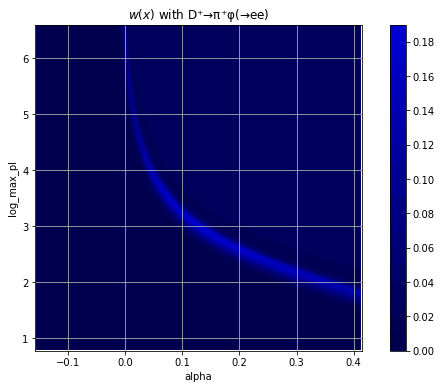

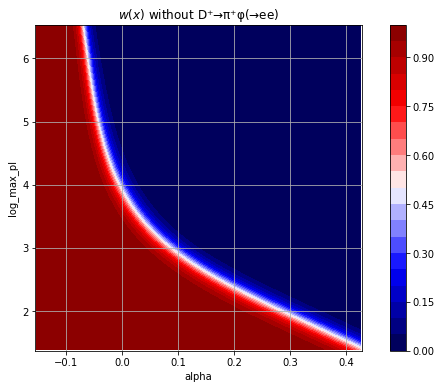

In [62]:
plot_field(w_la.w_model_np(), w_la.dataset(), r'$w(x)$ with %s'%df_index[3], save='result_la.pdf')
plot_field(w_la3.w_model_np(), w_la3.dataset(), r'$w(x)$ without %s'%df_index[3], save='result_la3.pdf')

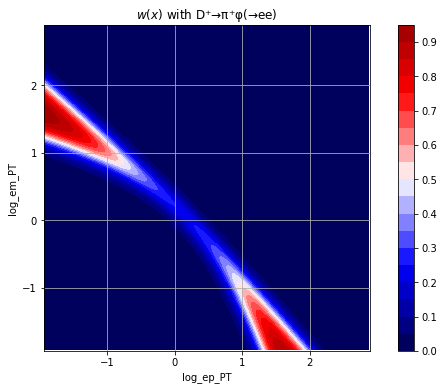

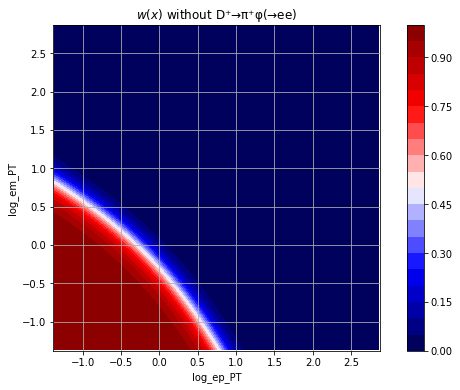

In [63]:
plot_field(w_ptpt.w_model_np(), w_ptpt.dataset(), r'$w(x)$ with %s'%df_index[3])
plot_field(w_ptpt3.w_model_np(), w_ptpt3.dataset(), r'$w(x)$ without %s'%df_index[3])

In [64]:
df = df.iloc[0:8,0:3]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

In [66]:
for name, w in [("w₄[α,p]", w_la), ("w₃[α,p]", w_la3), ("w₄[pt,pt]", w_ptpt), ("w₃[pt,pt]", w_ptpt3)]:
    ds = w.dataset()
    name1 = "1-%s" % name
    r_name = "R[%s]" % name
    df[name1] = None
    for label, idx in ds.mapping.items():
        d = ds.X[ds.Y==label]
        wd = w.w_model_np()(d)
        df.loc[df.index[idx],name1] = 1-np.mean(wd)
    df[r_name] = None
    for label, idx in ds.mapping.items():
        df.loc[df.index[idx],r_name] = df.loc[df.index[1],name1] / df.loc[df.index[idx],name1]
df

Total       N   N/Total 1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p]  \
B⁺→K⁺ee          970116  247104  0.254716  0.951721    1.02839  0.897936   
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259   0.97874        1.0  0.994284   
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759  0.978742   0.999998  0.994284   
D⁺→π⁺φ(→ee)      830027  830027  1.000000  0.978757   0.999982      None   

                R[w₃[α,p]] 1-w₄[pt,pt] R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]  
B⁺→K⁺ee           1.107299     0.92487     1.032822    0.910814     1.078101  
B⁺→K⁺J/ψ(→ee)          1.0    0.955225          1.0    0.981949          1.0  
B⁺→K⁺ψ(2S)(→ee)        1.0    0.955227     0.999998    0.981979      0.99997  
D⁺→π⁺φ(→ee)           None    0.955191     1.000036        None         None

### Conditional plots

In [69]:
def plot_e(w_obj, feature, bins, comment=None):
    ds = w_obj.dataset()
    ds_features = ds.features
    ds_comment = ds_features if comment is None else "%s, %s" % (ds_features, comment)
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = w_obj.w_model_np()
    bins_q2 = np.linspace(0,14e6,101)
    for label, idx in ds.mapping.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label,0]
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        plt.step(bins[:-1], hd, where='post', label=df_index[idx])
    plt.title("e(%s) for %s" % (feature, ds_comment))
    plt.legend()
    plt.grid()
    plt.show()

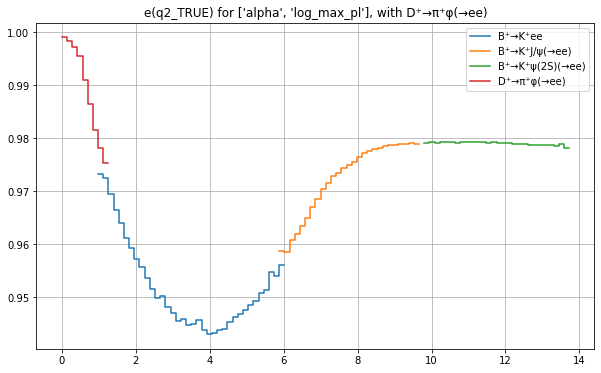

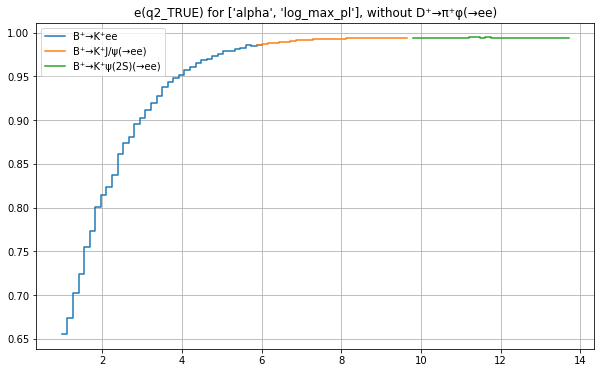

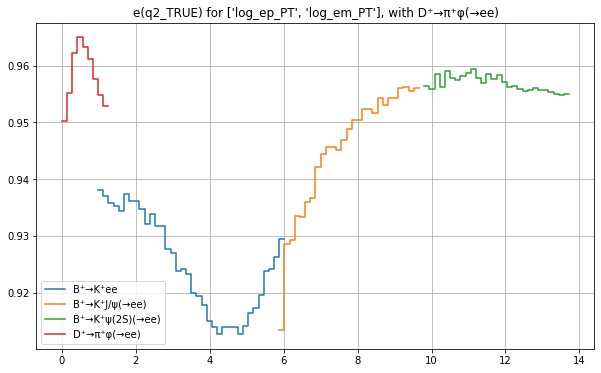

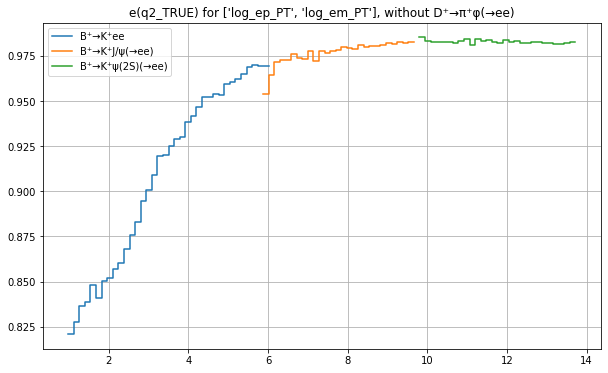

In [70]:
plot_e(w_la, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_la3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])

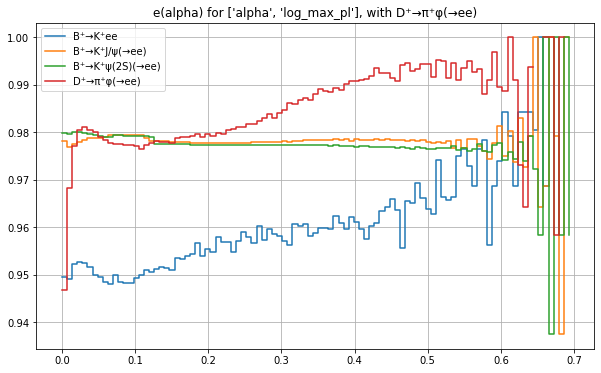

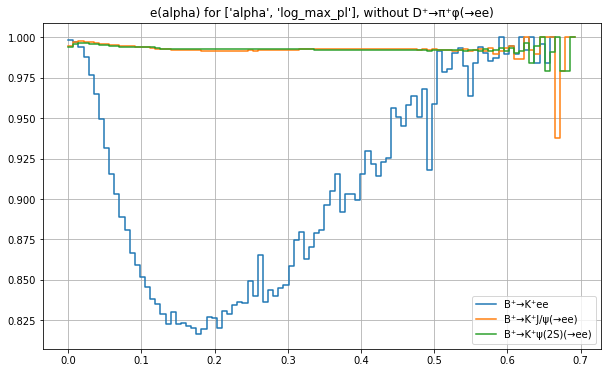

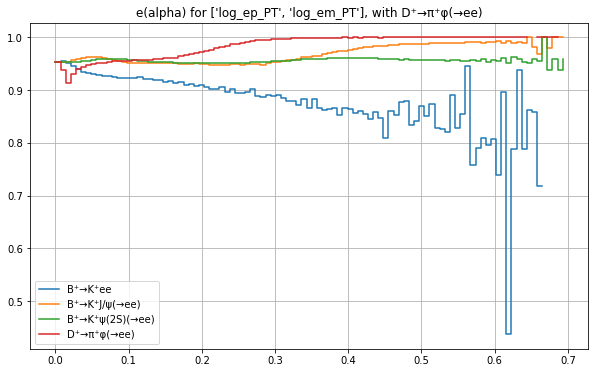

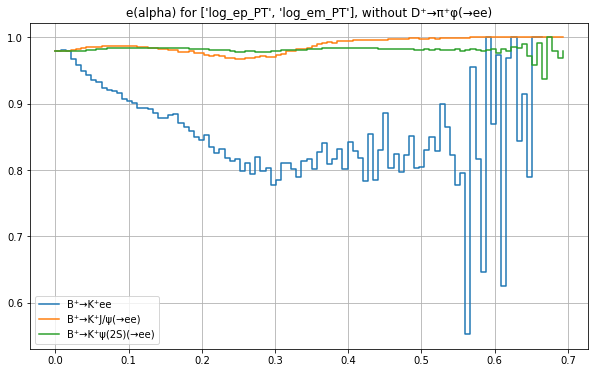

In [71]:
plot_e(w_la, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_la3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])

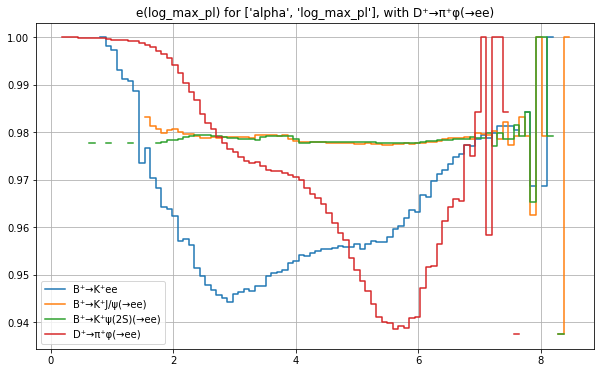

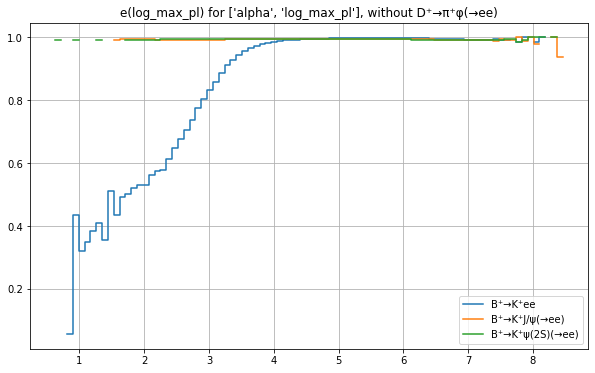

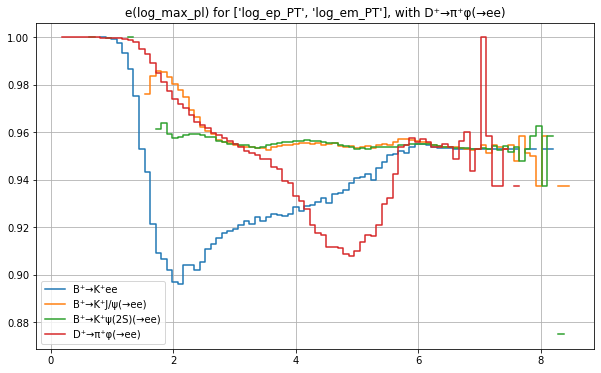

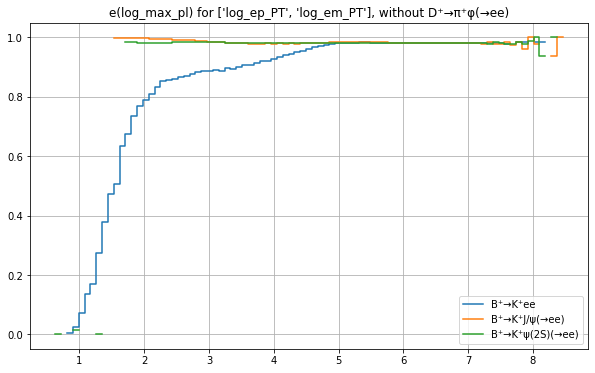

In [72]:
plot_e(w_la, "log_max_pl", bins=np.linspace(0,9,101), comment="with %s" % df_index[3])
plot_e(w_la3, "log_max_pl", bins=np.linspace(0,9,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(0,9,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(0,9,101), comment="without %s" % df_index[3])

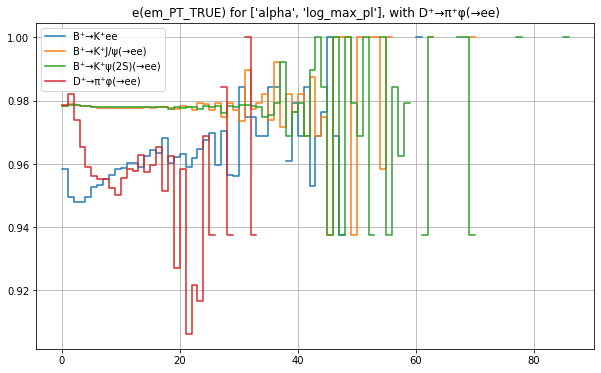

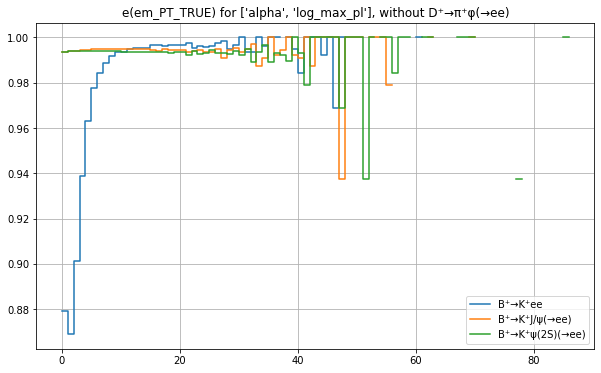

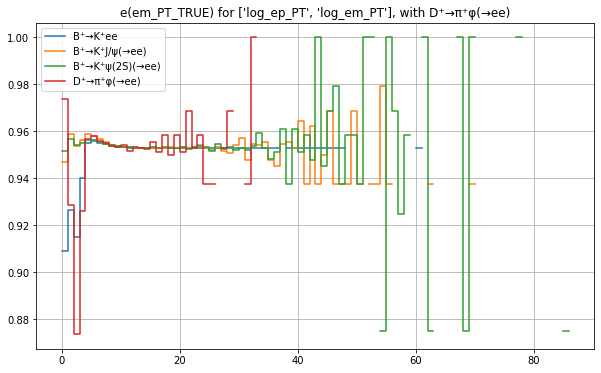

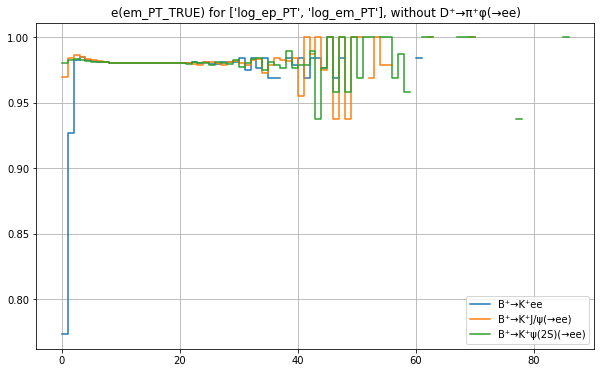

In [73]:
plot_e(w_la, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_la3, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])

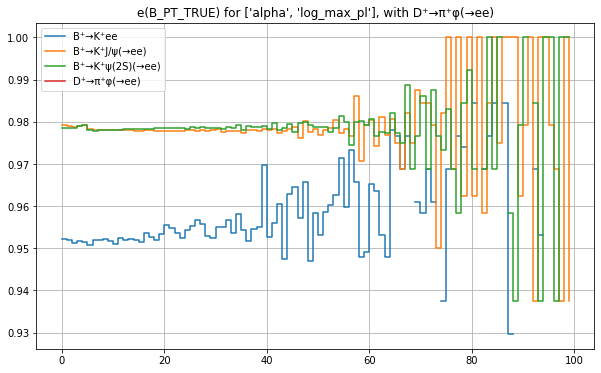

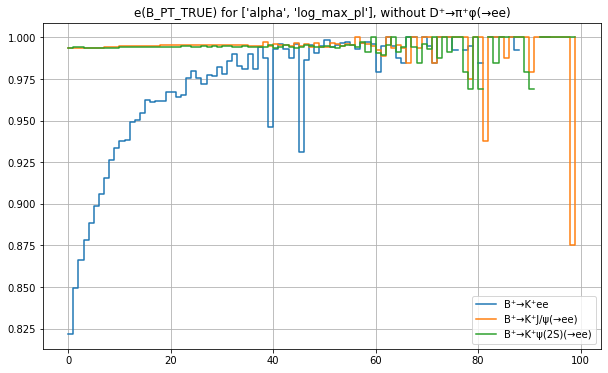

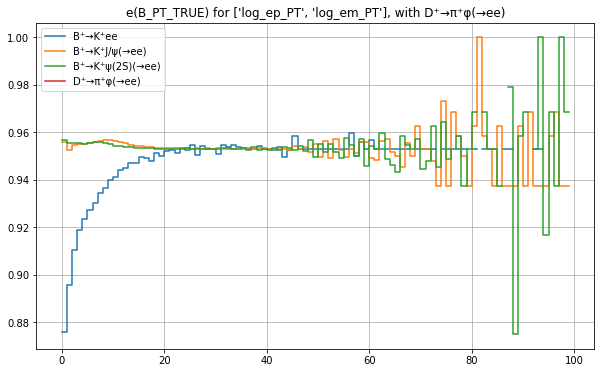

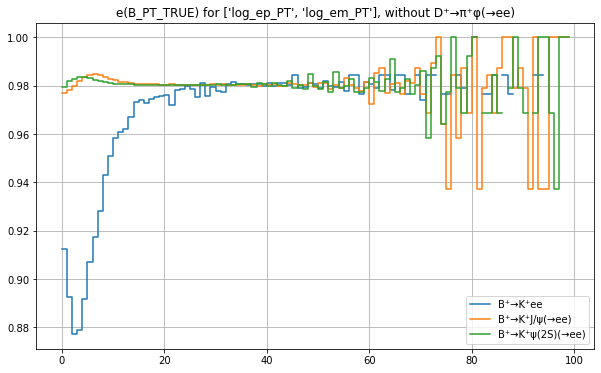

In [74]:
plot_e(w_la, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_la3, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])

### Single feature

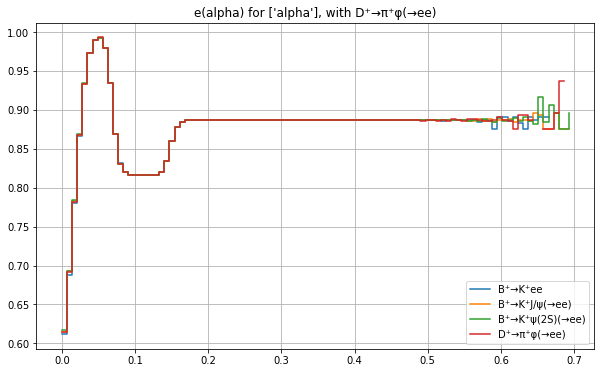

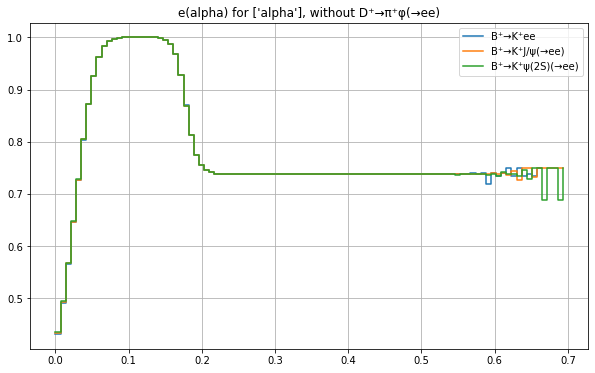

In [75]:
plot_e(w_a4, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_a3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])

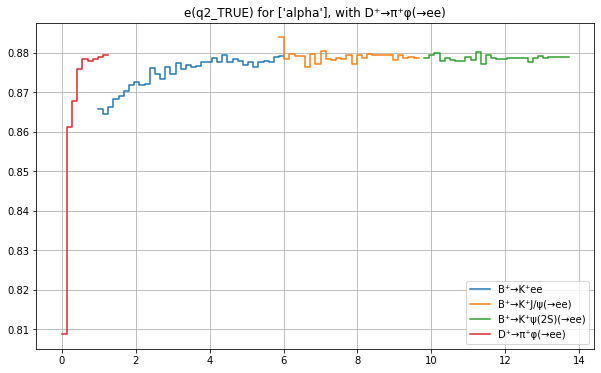

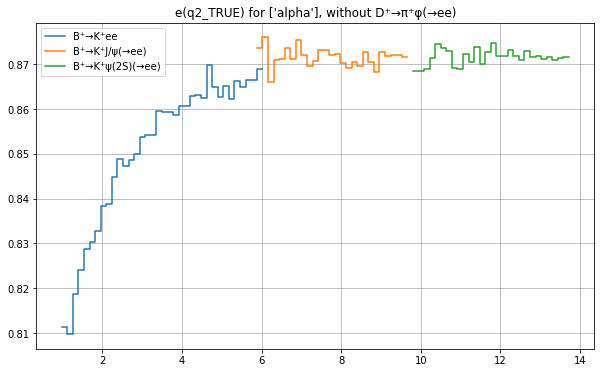

In [76]:
plot_e(w_a4, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_a3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])